# IVI ML Model - Three-Phase Approach

This notebook implements a data-driven IVI (Intelligent Value Index) scoring model.

## Approach
Instead of hand-crafting penalty functions, we let the model learn non-linear relationships:

**Phase 1: Baseline Gradient Boosting Model**
- Train LightGBM to predict retention (2022 -> 2023)
- Handle class imbalance (85% churn vs 15% retained)
- IVI Score = Retention Probability * 100

**Phase 2: Interpretability with SHAP**
- Extract H, E, U sub-scores from SHAP values
- Understand which KPIs drive retention
- Validate model makes business sense

**Phase 3: Business Segmentation**
- Multi-dimensional segmentation (not just IVI)
- Risk categories based on business rules + model
- Actionable recommendations per segment

## Data Caveats
- **Severe Class Imbalance:** 85% churn, 15% retained
- **Only 2 Years:** 2022 features -> 2023 retention (no Year 3 validation)
- See IMPLEMENTATION_NOTES.md for full details

In [2]:
!uv pip install lightgbm xgboost catboost --system -q

In [3]:
# Import Required Libraries
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix, f1_score, roc_curve
)
import lightgbm as lgb
import shap

warnings.filterwarnings('ignore')

# Paths
DATA_DIR = Path('/volume/data/processed')
OUTPUT_DIR = Path('/volume/data/models')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print(f'Data directory: {DATA_DIR}')
print(f'Model output directory: {OUTPUT_DIR}')

Data directory: /volume/data/processed
Model output directory: /volume/data/models


## 1. Load and Prepare Data

In [4]:
# Load contract-year level data
df = pl.read_parquet(DATA_DIR / 'contract_year_level.parquet')

# Fix LOSS_RATIO: recompute using WRITTEN_PREMIUM (currency) instead of EARNED_PREMIUM
# (In the raw data, EARNED_PREMIUM behaves like exposure, not monetary premium.)
if {'TOTAL_BILLED', 'WRITTEN_PREMIUM'}.issubset(set(df.columns)):
    df = df.with_columns(
        pl.when(pl.col('WRITTEN_PREMIUM') > 0)
        .then(pl.col('TOTAL_BILLED') / pl.col('WRITTEN_PREMIUM'))
        .otherwise(None)
        .alias('LOSS_RATIO')
    )

print(f'Total rows: {df.height:,}')
print(f'Total columns: {df.width}')
print(f'\nYears in data: {sorted(df["YEAR"].unique().to_list())}')
print(f'\nContracts by year:')
print(df.group_by('YEAR').agg(pl.col('CONTRACT_NO').n_unique().alias('contracts')).sort('YEAR'))

Total rows: 143,596
Total columns: 77

Years in data: ['2022', '2023']

Contracts by year:
shape: (2, 2)
┌──────┬───────────┐
│ YEAR ┆ contracts │
│ ---  ┆ ---       │
│ str  ┆ u32       │
╞══════╪═══════════╡
│ 2022 ┆ 65779     │
│ 2023 ┆ 77817     │
└──────┴───────────┘


In [5]:
# Filter to 2022 data (our training set with retention labels)
df_2022 = df.filter(pl.col('YEAR') == '2022')

print(f'2022 contracts: {df_2022.height:,}')
print(f'\nTarget distribution:')
print(df_2022.group_by('RETAINED_NEXT_YEAR').agg(pl.len().alias('count')))

# Calculate class weights for imbalanced data
retained_count = df_2022.filter(pl.col('RETAINED_NEXT_YEAR') == 1).height
churned_count = df_2022.filter(pl.col('RETAINED_NEXT_YEAR') == 0).height
total = df_2022.height

print(f'\nClass Imbalance:')
print(f'  Retained: {retained_count:,} ({retained_count/total*100:.1f}%)')
print(f'  Churned:  {churned_count:,} ({churned_count/total*100:.1f}%)')
print(f'  Imbalance ratio: 1:{churned_count/retained_count:.1f}')

2022 contracts: 65,779

Target distribution:
shape: (2, 2)
┌────────────────────┬───────┐
│ RETAINED_NEXT_YEAR ┆ count │
│ ---                ┆ ---   │
│ i8                 ┆ u32   │
╞════════════════════╪═══════╡
│ 0                  ┆ 55887 │
│ 1                  ┆ 9892  │
└────────────────────┴───────┘

Class Imbalance:
  Retained: 9,892 (15.0%)
  Churned:  55,887 (85.0%)
  Imbalance ratio: 1:5.6


## 1.1 Contract Churn Analysis: Who Left vs Who Joined?

Before filtering, let's understand the contract dynamics between 2022 and 2023.

In [6]:
# Analyze contract churn: Who left (2022 only) vs Who joined (2023 only) vs Who stayed (both years)
contracts_2022 = set(df.filter(pl.col('YEAR') == '2022')['CONTRACT_NO'].unique().to_list())
contracts_2023 = set(df.filter(pl.col('YEAR') == '2023')['CONTRACT_NO'].unique().to_list())

churned_contracts = contracts_2022 - contracts_2023  # In 2022, not in 2023
new_contracts = contracts_2023 - contracts_2022      # In 2023, not in 2022
retained_contracts = contracts_2022 & contracts_2023  # In both years

print('CONTRACT DYNAMICS BETWEEN 2022 AND 2023')
print('=' * 70)
print(f'Total 2022 contracts:     {len(contracts_2022):,}')
print(f'Total 2023 contracts:     {len(contracts_2023):,}')
print(f'\nChurned (2022 only):      {len(churned_contracts):,} ({len(churned_contracts)/len(contracts_2022)*100:.1f}%)')
print(f'New (2023 only):          {len(new_contracts):,}')
print(f'Retained (both years):    {len(retained_contracts):,} ({len(retained_contracts)/len(contracts_2022)*100:.1f}%)')

# Get detailed stats for each group
def get_contract_stats(contract_list, year, df_source):
    """Get stats for a list of contracts in a given year."""
    if len(contract_list) == 0:
        return None
    
    df_subset = df_source.filter(
        (pl.col('CONTRACT_NO').is_in(list(contract_list))) & 
        (pl.col('YEAR') == year)
    )
    
    stats = {
        'count': len(contract_list),
        'total_members': df_subset['TOTAL_MEMBERS'].sum(),
        'avg_members': df_subset['TOTAL_MEMBERS'].mean(),
        'median_members': df_subset['TOTAL_MEMBERS'].median(),
        'total_premium': df_subset['WRITTEN_PREMIUM'].sum() if 'WRITTEN_PREMIUM' in df_subset.columns else 0,
        'avg_premium': df_subset['WRITTEN_PREMIUM'].mean() if 'WRITTEN_PREMIUM' in df_subset.columns else 0,
        'total_billed': df_subset['TOTAL_BILLED'].sum() if 'TOTAL_BILLED' in df_subset.columns else 0,
        'avg_loss_ratio': df_subset['LOSS_RATIO'].mean() if 'LOSS_RATIO' in df_subset.columns else 0,
    }
    
    # Size distribution
    if 'TOTAL_MEMBERS' in df_subset.columns:
        members = df_subset['TOTAL_MEMBERS']
        stats['small_contracts'] = members.filter(members < 15).len()
        stats['medium_contracts'] = members.filter((members >= 15) & (members < 100)).len()
        stats['large_contracts'] = members.filter(members >= 100).len()
    
    # Region distribution (top 3)
    if 'PRIMARY_REGION' in df_subset.columns:
        region_counts = df_subset.group_by('PRIMARY_REGION').agg(pl.len().alias('count')).sort('count', descending=True)
        stats['top_regions'] = region_counts.head(3).to_pandas().to_dict('records')
    
    return stats

# Get stats for each group
churned_stats = get_contract_stats(churned_contracts, '2022', df)
new_stats = get_contract_stats(new_contracts, '2023', df)
retained_stats_2022 = get_contract_stats(retained_contracts, '2022', df)

print('\n' + '=' * 70)
print('CHURNED CONTRACTS (In 2022, NOT in 2023)')
print('=' * 70)
if churned_stats:
    print(f'  Contract count:       {churned_stats["count"]:,}')
    print(f'  Total members:        {churned_stats["total_members"]:,.0f}')
    print(f'  Avg members/contract: {churned_stats["avg_members"]:.1f}')
    print(f'  Median members:       {churned_stats["median_members"]:.0f}')
    print(f'  Total premium:        {churned_stats["total_premium"]:,.0f}')
    print(f'  Avg loss ratio:       {churned_stats["avg_loss_ratio"]:.2%}')
    print(f'\n  Size Distribution:')
    print(f'    Small (<15 members):    {churned_stats["small_contracts"]:,} ({churned_stats["small_contracts"]/churned_stats["count"]*100:.1f}%)')
    print(f'    Medium (15-99 members): {churned_stats["medium_contracts"]:,} ({churned_stats["medium_contracts"]/churned_stats["count"]*100:.1f}%)')
    print(f'    Large (100+ members):   {churned_stats["large_contracts"]:,} ({churned_stats["large_contracts"]/churned_stats["count"]*100:.1f}%)')
    if 'top_regions' in churned_stats:
        print(f'\n  Top Regions:')
        for r in churned_stats['top_regions']:
            print(f'    {r["PRIMARY_REGION"]}: {r["count"]:,}')

print('\n' + '=' * 70)
print('NEW CONTRACTS (In 2023, NOT in 2022)')
print('=' * 70)
if new_stats:
    print(f'  Contract count:       {new_stats["count"]:,}')
    print(f'  Total members:        {new_stats["total_members"]:,.0f}')
    print(f'  Avg members/contract: {new_stats["avg_members"]:.1f}')
    print(f'  Median members:       {new_stats["median_members"]:.0f}')
    print(f'  Total premium:        {new_stats["total_premium"]:,.0f}')
    print(f'  Avg loss ratio:       {new_stats["avg_loss_ratio"]:.2%}')
    print(f'\n  Size Distribution:')
    print(f'    Small (<15 members):    {new_stats["small_contracts"]:,} ({new_stats["small_contracts"]/new_stats["count"]*100:.1f}%)')
    print(f'    Medium (15-99 members): {new_stats["medium_contracts"]:,} ({new_stats["medium_contracts"]/new_stats["count"]*100:.1f}%)')
    print(f'    Large (100+ members):   {new_stats["large_contracts"]:,} ({new_stats["large_contracts"]/new_stats["count"]*100:.1f}%)')
    if 'top_regions' in new_stats:
        print(f'\n  Top Regions:')
        for r in new_stats['top_regions']:
            print(f'    {r["PRIMARY_REGION"]}: {r["count"]:,}')

print('\n' + '=' * 70)
print('RETAINED CONTRACTS (In both 2022 and 2023)')
print('=' * 70)
if retained_stats_2022:
    print(f'  Contract count:       {retained_stats_2022["count"]:,}')
    print(f'  Total members (2022): {retained_stats_2022["total_members"]:,.0f}')
    print(f'  Avg members/contract: {retained_stats_2022["avg_members"]:.1f}')
    print(f'  Median members:       {retained_stats_2022["median_members"]:.0f}')
    print(f'  Total premium (2022): {retained_stats_2022["total_premium"]:,.0f}')
    print(f'  Avg loss ratio:       {retained_stats_2022["avg_loss_ratio"]:.2%}')
    print(f'\n  Size Distribution:')
    print(f'    Small (<15 members):    {retained_stats_2022["small_contracts"]:,} ({retained_stats_2022["small_contracts"]/retained_stats_2022["count"]*100:.1f}%)')
    print(f'    Medium (15-99 members): {retained_stats_2022["medium_contracts"]:,} ({retained_stats_2022["medium_contracts"]/retained_stats_2022["count"]*100:.1f}%)')
    print(f'    Large (100+ members):   {retained_stats_2022["large_contracts"]:,} ({retained_stats_2022["large_contracts"]/retained_stats_2022["count"]*100:.1f}%)')

CONTRACT DYNAMICS BETWEEN 2022 AND 2023
Total 2022 contracts:     65,779
Total 2023 contracts:     77,817

Churned (2022 only):      55,887 (85.0%)
New (2023 only):          67,925
Retained (both years):    9,892 (15.0%)

CHURNED CONTRACTS (In 2022, NOT in 2023)
  Contract count:       55,887
  Total members:        674,137
  Avg members/contract: 12.1
  Median members:       1
  Total premium:        7,981,285,602
  Avg loss ratio:       22.39%

  Size Distribution:
    Small (<15 members):    51,881 (92.8%)
    Medium (15-99 members): 3,014 (5.4%)
    Large (100+ members):   992 (1.8%)

  Top Regions:
    None: 46,448
    Central: 3,997
    Western: 3,617

NEW CONTRACTS (In 2023, NOT in 2022)
  Contract count:       67,925
  Total members:        651,070
  Avg members/contract: 9.6
  Median members:       1
  Total premium:        9,184,090,213
  Avg loss ratio:       35.33%

  Size Distribution:
    Small (<15 members):    63,894 (94.1%)
    Medium (15-99 members): 3,261 (4.8%)
    

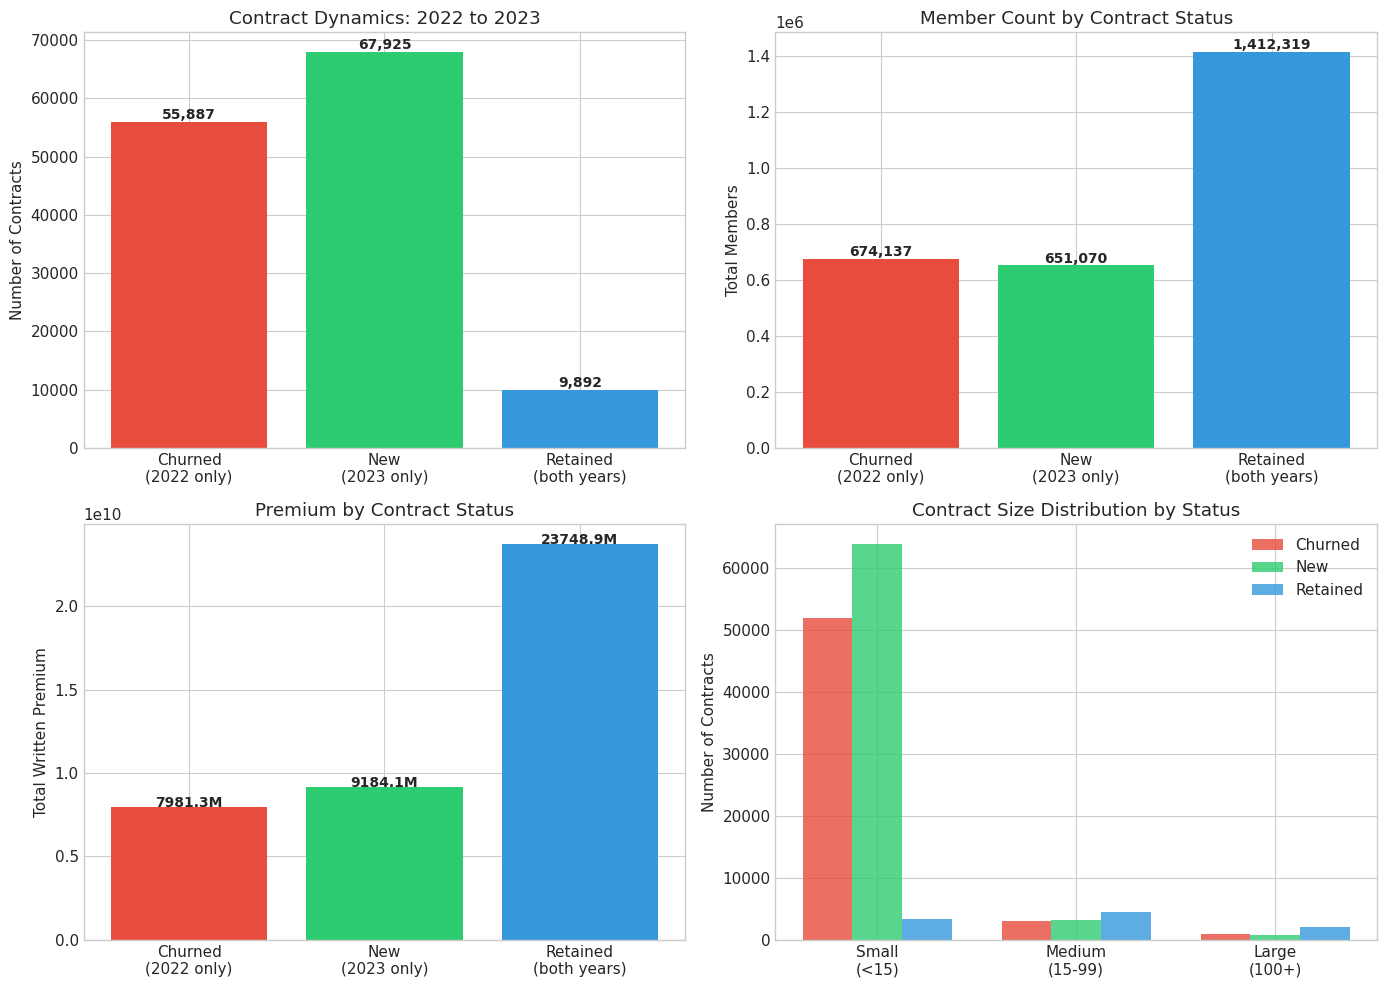


KEY INSIGHTS:
- 92.8% of churned contracts are small (<15 members)
- Retained contracts represent 23.75B in premium
- Churned contracts represent 7.98B in premium


In [7]:
# Visualization: Churn Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Contract counts by status
ax = axes[0, 0]
statuses = ['Churned\n(2022 only)', 'New\n(2023 only)', 'Retained\n(both years)']
counts = [len(churned_contracts), len(new_contracts), len(retained_contracts)]
colors = ['#e74c3c', '#2ecc71', '#3498db']
bars = ax.bar(statuses, counts, color=colors)
ax.set_ylabel('Number of Contracts')
ax.set_title('Contract Dynamics: 2022 to 2023')
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, f'{count:,}', 
            ha='center', fontsize=10, fontweight='bold')

# 2. Member distribution by status
ax = axes[0, 1]
member_totals = [
    churned_stats['total_members'] if churned_stats else 0,
    new_stats['total_members'] if new_stats else 0,
    retained_stats_2022['total_members'] if retained_stats_2022 else 0
]
bars = ax.bar(statuses, member_totals, color=colors)
ax.set_ylabel('Total Members')
ax.set_title('Member Count by Contract Status')
for bar, count in zip(bars, member_totals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10000, f'{count:,.0f}', 
            ha='center', fontsize=10, fontweight='bold')

# 3. Premium by status
ax = axes[1, 0]
premium_totals = [
    churned_stats['total_premium'] if churned_stats else 0,
    new_stats['total_premium'] if new_stats else 0,
    retained_stats_2022['total_premium'] if retained_stats_2022 else 0
]
bars = ax.bar(statuses, premium_totals, color=colors)
ax.set_ylabel('Total Written Premium')
ax.set_title('Premium by Contract Status')
for bar, count in zip(bars, premium_totals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{count/1e6:.1f}M', 
            ha='center', fontsize=10, fontweight='bold')

# 4. Size distribution comparison
ax = axes[1, 1]
x = np.arange(3)
width = 0.25

all_stats = [churned_stats, new_stats, retained_stats_2022]
for i, (stat, status, color) in enumerate(zip(all_stats, ['Churned', 'New', 'Retained'], colors)):
    if stat:
        sizes = [stat['small_contracts'], stat['medium_contracts'], stat['large_contracts']]
        ax.bar(x + i*width, sizes, width, label=status, color=color, alpha=0.8)

ax.set_xticks(x + width)
ax.set_xticklabels(['Small\n(<15)', 'Medium\n(15-99)', 'Large\n(100+)'])
ax.set_ylabel('Number of Contracts')
ax.set_title('Contract Size Distribution by Status')
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'churn_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary insight
total_churned_premium = churned_stats['total_premium'] if churned_stats else 0
total_retained_premium = retained_stats_2022['total_premium'] if retained_stats_2022 else 0
small_churned = churned_stats['small_contracts'] if churned_stats else 0
small_churned_pct = small_churned / len(churned_contracts) * 100 if len(churned_contracts) > 0 else 0

print('\nKEY INSIGHTS:')
print(f'- {small_churned_pct:.1f}% of churned contracts are small (<15 members)')
print(f'- Retained contracts represent {total_retained_premium/1e9:.2f}B in premium')
print(f'- Churned contracts represent {total_churned_premium/1e9:.2f}B in premium')

## 1.2 Filter Small Contractors

Small contractors (<15 members) constitute the majority of contracts but a small portion of premium/profit. 
They also create noise in the model due to high variance in their metrics.
We filter them out to focus on business-relevant contracts.

In [8]:
# Filter out small contractors (<5 members) and analyze the impact
MIN_MEMBERS = 5

# Before filtering stats
total_before = df.height
contracts_before = df['CONTRACT_NO'].n_unique()
premium_before = df['WRITTEN_PREMIUM'].sum() if 'WRITTEN_PREMIUM' in df.columns else 0
members_before = df['TOTAL_MEMBERS'].sum()

# Apply filter
df = df.filter(pl.col('TOTAL_MEMBERS') >= MIN_MEMBERS)

# After filtering stats
total_after = df.height
contracts_after = df['CONTRACT_NO'].n_unique()
premium_after = df['WRITTEN_PREMIUM'].sum() if 'WRITTEN_PREMIUM' in df.columns else 0
members_after = df['TOTAL_MEMBERS'].sum()

print('FILTERING SMALL CONTRACTORS (<5 members)')
print('=' * 70)
print(f'\n{"Metric":<25} {"Before":>15} {"After":>15} {"Removed":>15}')
print('-' * 70)
print(f'{"Contract-years":<25} {total_before:>15,} {total_after:>15,} {total_before - total_after:>15,}')
print(f'{"Unique contracts":<25} {contracts_before:>15,} {contracts_after:>15,} {contracts_before - contracts_after:>15,}')
print(f'{"Total members":<25} {members_before:>15,.0f} {members_after:>15,.0f} {members_before - members_after:>15,.0f}')
print(f'{"Written premium":<25} {premium_before:>15,.0f} {premium_after:>15,.0f} {premium_before - premium_after:>15,.0f}')

print(f'\nREMOVAL IMPACT:')
print(f'  Contracts removed: {(contracts_before - contracts_after)/contracts_before*100:.1f}%')
print(f'  Members removed:   {(members_before - members_after)/members_before*100:.1f}%')
print(f'  Premium removed:   {(premium_before - premium_after)/premium_before*100:.1f}%')

# Update 2022 filter
df_2022 = df.filter(pl.col('YEAR') == '2022')

print(f'\nUpdated 2022 data:')
print(f'  Contracts: {df_2022.height:,}')
print(f'  Retained:  {df_2022.filter(pl.col("RETAINED_NEXT_YEAR") == 1).height:,}')
print(f'  Churned:   {df_2022.filter(pl.col("RETAINED_NEXT_YEAR") == 0).height:,}')

# Recalculate class balance
retained_count = df_2022.filter(pl.col('RETAINED_NEXT_YEAR') == 1).height
churned_count = df_2022.filter(pl.col('RETAINED_NEXT_YEAR') == 0).height
total = df_2022.height

print(f'\nUpdated Class Balance:')
print(f'  Retained: {retained_count:,} ({retained_count/total*100:.1f}%)')
print(f'  Churned:  {churned_count:,} ({churned_count/total*100:.1f}%)')
print(f'  Imbalance ratio: 1:{churned_count/retained_count:.1f}')

FILTERING SMALL CONTRACTORS (<5 members)

Metric                             Before           After         Removed
----------------------------------------------------------------------
Contract-years                    143,596          31,346         112,250
Unique contracts                  133,704          22,980         110,724
Total members                   4,201,467       4,073,482         127,985
Written premium            69,386,332,785  68,946,536,135     439,796,649

REMOVAL IMPACT:
  Contracts removed: 82.8%
  Members removed:   3.0%
  Premium removed:   0.6%

Updated 2022 data:
  Contracts: 15,364
  Retained:  8,664
  Churned:   6,700

Updated Class Balance:
  Retained: 8,664 (56.4%)
  Churned:  6,700 (43.6%)
  Imbalance ratio: 1:0.8


In [9]:
# Define feature groups (H, E, U dimensions)
# This mapping will be used for SHAP decomposition later

FEATURE_GROUPS = {
    'H_HEALTH': [
        'MEMBERS_WITH_CLAIMS', 'UNIQUE_DIAGNOSES', 'DIAGNOSES_PER_UTILIZER',
        'CLAIM_LINES', 'UNIQUE_CLAIMS', 'CLAIMS_PER_UTILIZER',
        'TOTAL_BILLED', 'AVG_CLAIM_AMOUNT', 'MAX_CLAIM_AMOUNT', 'P90_CLAIM_AMOUNT',
        'STD_CLAIM_AMOUNT', 'UTILIZATION_RATE',
    ],
    'E_EXPERIENCE': [
        'TOTAL_CALLS', 'UNIQUE_CALLS', 'UNIQUE_CALLERS', 'CALLS_PER_MEMBER',
        'AVG_RESOLUTION_DAYS', 'MEDIAN_RESOLUTION_DAYS', 'CALL_CATEGORIES',
        'PREAUTH_EPISODES', 'PREAUTH_ITEMS', 'MEMBERS_WITH_PREAUTH',
        'APPROVAL_RATE', 'REJECTION_RATE', 'PREAUTH_PER_MEMBER',
        'WEEKEND_CALLS', 'WEEKDAY_CALLS',
    ],
    'U_UTILIZATION': [
        'LOSS_RATIO', 'COST_PER_MEMBER', 'COST_PER_UTILIZER',
        'TOTAL_EST_AMOUNT', 'AVG_EST_AMOUNT', 'MAX_EST_AMOUNT',
        'WRITTEN_PREMIUM', 'EARNED_PREMIUM', 'AVG_PREMIUM_PER_MEMBER',
        'CLAIM_LINES_PER_MEMBER', 'PROVIDERS_PER_UTILIZER',
    ],
    'DEMOGRAPHICS': [
        'TOTAL_MEMBERS', 'PLAN_COUNT', 'MALE_COUNT', 'FEMALE_COUNT',
        'MALE_RATIO', 'NATIONALITY_COUNT', 'NETWORK_COUNT',
    ],
    'SEASONAL': [
        'Q1_CLAIMS', 'Q2_CLAIMS', 'Q3_CLAIMS', 'Q4_CLAIMS',
        'Q1_CALLS', 'Q2_CALLS', 'Q3_CALLS', 'Q4_CALLS',
        'QUARTER_CONCENTRATION', 'ACTIVE_MONTHS', 'ACTIVE_CALL_MONTHS',
        'ACTIVE_PREAUTH_MONTHS', 'YEAR_COVERAGE',
    ],
    'PROVIDER': [
        'UNIQUE_PROVIDERS', 'PREAUTH_PROVIDERS',
    ],
    'REGION_NETWORK': [
        'REGION_COUNT', 'NETWORK_COUNT_USED', 'PRACTICE_TYPE_COUNT', 'REGION_CONCENTRATION',
    ],
}

# Flatten to get all features
ALL_FEATURES = [f for group in FEATURE_GROUPS.values() for f in group]
print(f'Total features defined: {len(ALL_FEATURES)}')
print(f'\nFeature groups:')
for group, features in FEATURE_GROUPS.items():
    print(f'  {group}: {len(features)} features')

Total features defined: 64

Feature groups:
  H_HEALTH: 12 features
  E_EXPERIENCE: 15 features
  U_UTILIZATION: 11 features
  DEMOGRAPHICS: 7 features
  SEASONAL: 13 features
  PROVIDER: 2 features
  REGION_NETWORK: 4 features


In [17]:
# Prepare features and target
# Filter to features that actually exist in the dataframe
available_features = [f for f in ALL_FEATURES if f in df_2022.columns]
missing_features = [f for f in ALL_FEATURES if f not in df_2022.columns]

print(f'Available features: {len(available_features)}')
if missing_features:
    print(f'Missing features (will skip): {missing_features}')

# Also add PRIMARY_REGION and PRIMARY_NETWORK as categorical features
# We'll encode them as dummy variables
region_network_cols = ['PRIMARY_REGION', 'PRIMARY_NETWORK']

# Convert to pandas for sklearn compatibility
base_cols = ['CONTRACT_NO'] + available_features + ['RETAINED_NEXT_YEAR']
cat_cols = [c for c in region_network_cols if c in df_2022.columns]
df_ml = df_2022.select(base_cols + cat_cols).to_pandas()

# Handle any remaining nulls
df_ml = df_ml.fillna(0)

# Replace infinities
df_ml = df_ml.replace([np.inf, -np.inf], 0)

# One-hot encode categorical region/network features
if cat_cols:
    df_ml['PRIMARY_REGION'] = df_ml['PRIMARY_REGION'].fillna('Unknown').astype(str)
    df_ml['PRIMARY_NETWORK'] = df_ml['PRIMARY_NETWORK'].fillna('Unknown').astype(str)
    
    # Create dummies
    region_dummies = pd.get_dummies(df_ml['PRIMARY_REGION'], prefix='REGION')
    network_dummies = pd.get_dummies(df_ml['PRIMARY_NETWORK'], prefix='NETWORK')
    
    # Add to features
    df_ml = pd.concat([df_ml, region_dummies, network_dummies], axis=1)
    
    # Update available features list
    available_features = available_features + list(region_dummies.columns) + list(network_dummies.columns)
    
    print(f'\nAdded {len(region_dummies.columns)} region dummies and {len(network_dummies.columns)} network dummies')

X = df_ml[available_features]
y = df_ml['RETAINED_NEXT_YEAR']
contract_ids = df_ml['CONTRACT_NO']

print(f'\nFeature matrix shape: {X.shape}')
print(f'Target shape: {y.shape}')
print(f'\nTarget distribution:')

Available features: 64

Added 7 region dummies and 13 network dummies

Feature matrix shape: (15364, 84)
Target shape: (15364,)

Target distribution:


In [18]:
# Train/validation/test split with stratification (important for imbalanced data)
# - Train: fit model
# - Validation: early stopping + probability calibration
# - Test: final, unbiased evaluation
X_trainval, X_test, y_trainval, y_test, contracts_trainval, contracts_test = train_test_split(
    X,
    y,
    contract_ids,
    test_size=0.2,
    random_state=42,
    stratify=y,  # Maintain class proportions
)

X_train, X_val, y_train, y_val, contracts_train, contracts_val = train_test_split(
    X_trainval,
    y_trainval,
    contracts_trainval,
    test_size=0.2,
    random_state=42,
    stratify=y_trainval,
)

print(f'Train set:      {X_train.shape[0]:,} contracts')
print(f'Validation set: {X_val.shape[0]:,} contracts')
print(f'Test set:       {X_test.shape[0]:,} contracts')

print('\nTarget distribution (proportions):')
print(
    pd.DataFrame(
        {
            'train': y_train.value_counts(normalize=True),
            'val': y_val.value_counts(normalize=True),
            'test': y_test.value_counts(normalize=True),
        }
    )
    .fillna(0)
    .rename(index={0: 'Churned', 1: 'Retained'})
)

Train set:      9,832 contracts
Validation set: 2,459 contracts
Test set:       3,073 contracts

Target distribution (proportions):
                       train      val      test
RETAINED_NEXT_YEAR                             
Retained            0.563873  0.56405  0.563944
Churned             0.436127  0.43595  0.436056


## Phase 1: Baseline Gradient Boosting Model

Using LightGBM with class weight balancing to handle the 85/15 imbalance.

In [19]:
# Calculate scale_pos_weight for imbalanced data
# With MIN_MEMBERS=5 filter, class balance is now ~56/44 (much better!)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f'scale_pos_weight: {scale_pos_weight:.2f}')
print(f'Class balance: {(y_train == 1).mean()*100:.1f}% retained, {(y_train == 0).mean()*100:.1f}% churned')

# -----------------------------------------------------------------
# STRATEGY: With better class balance, focus on model quality
# The filtering to >=5 members gives ~56/44 split, much easier to model
# -----------------------------------------------------------------

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 500,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': 6,
    'min_child_samples': 30,
    'min_child_weight': 1e-3,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'reg_alpha': 0.1,  # L1 regularization
    'reg_lambda': 0.5,  # L2 regularization
    'scale_pos_weight': scale_pos_weight,  # Mild correction
    'random_state': 42,
    'verbose': -1,
}

print('\nTraining LightGBM model (early stopping on validation set)...')
model = lgb.LGBMClassifier(**lgb_params)
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(50, verbose=False)],
)

print(f'\nBest iteration: {model.best_iteration_}')
print(f'Best validation AUC: {model.best_score_["valid_0"]["auc"]:.4f}')

# -----------------------------------------------------------------
# Find threshold that MAXIMIZES MACRO F1 (balances both classes)
# -----------------------------------------------------------------
from sklearn.metrics import precision_recall_fscore_support

val_proba = model.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.3, 0.7, 21)  # Focus around 0.5 since balanced

print('\nThreshold optimization (Macro F1):')
print(f'{"Threshold":>10} {"Churn_F1":>10} {"Retain_F1":>10} {"Macro_F1":>10}')
print('-' * 42)

vals = []
for t in thresholds:
    pred = (val_proba >= t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_val, pred, labels=[0, 1], zero_division=0)
    macro_f1 = (f1[0] + f1[1]) / 2
    vals.append({
        'threshold': t,
        'churn_f1': f1[0],
        'retain_f1': f1[1],
        'macro_f1': macro_f1
    })
    if t in [0.3, 0.4, 0.5, 0.6, 0.7]:
        print(f'{t:>10.2f} {f1[0]:>10.3f} {f1[1]:>10.3f} {macro_f1:>10.3f}')

# Select threshold that maximizes MACRO F1 (balances both classes)
best_result = max(vals, key=lambda x: x['macro_f1'])
best_threshold = best_result['threshold']
best_f1 = best_result['macro_f1']

print(f'\nBest threshold (macro F1): {best_threshold:.2f}')
print(f'  Churned F1:  {best_result["churn_f1"]:.4f}')
print(f'  Retained F1: {best_result["retain_f1"]:.4f}')
print(f'  Macro F1:    {best_f1:.4f}')

scale_pos_weight: 0.77
Class balance: 56.4% retained, 43.6% churned

Training LightGBM model (early stopping on validation set)...

Best iteration: 48
Best validation AUC: 0.7136

Threshold optimization (Macro F1):
 Threshold   Churn_F1  Retain_F1   Macro_F1
------------------------------------------
      0.30      0.212      0.735      0.473
      0.70      0.632      0.268      0.450

Best threshold (macro F1): 0.50
  Churned F1:  0.6241
  Retained F1: 0.6897
  Macro F1:    0.6569


In [21]:
# Model Evaluation - Focus on BOTH classes
print('MODEL EVALUATION')
print('=' * 60)

# Direct probability predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Thresholded predictions
y_pred = (y_pred_proba >= best_threshold).astype(int)

# Metrics
auc_roc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)

print(f'\nOverall Metrics (Test Set):')
print(f'  AUC-ROC:           {auc_roc:.4f}')
print(f'  Average Precision: {avg_precision:.4f}')
print(f'  F1-Score (@{best_threshold:.2f}):  {f1:.4f}')

# Per-class metrics
p, r, f1_per, support = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1])
print(f'\nPer-Class Metrics (@{best_threshold:.2f}):')
print(f'{"Class":<12} {"Precision":>10} {"Recall":>10} {"F1-Score":>10} {"Support":>10}')
print('-' * 54)
print(f'{"Churned":<12} {p[0]:>10.3f} {r[0]:>10.3f} {f1_per[0]:>10.3f} {support[0]:>10}')
print(f'{"Retained":<12} {p[1]:>10.3f} {r[1]:>10.3f} {f1_per[1]:>10.3f} {support[1]:>10}')
print(f'{"Macro Avg":<12} {p.mean():>10.3f} {r.mean():>10.3f} {f1_per.mean():>10.3f} {support.sum():>10}')

print(f'\nClassification Report (@{best_threshold:.2f}):')
print(classification_report(y_test, y_pred, target_names=['Churned', 'Retained']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f'\nConfusion Matrix:')
print(f'                 Predicted')
print(f'                 Churn  Retain')
print(f'Actual Churn    {cm[0,0]:6d}  {cm[0,1]:6d}')
print(f'Actual Retain   {cm[1,0]:6d}  {cm[1,1]:6d}')

# Business interpretation
print('\nBusiness Interpretation:')
print(f'  True Positives (correctly predicted Retained): {cm[1,1]:,}')
print(f'  False Negatives (missed Retained - predicted Churn): {cm[1,0]:,}')
print(f'  False Positives (wrongly predicted Retained): {cm[0,1]:,}')
print(f'  True Negatives (correctly predicted Churn): {cm[0,0]:,}')

MODEL EVALUATION

Overall Metrics (Test Set):
  AUC-ROC:           0.7131
  Average Precision: 0.7561
  F1-Score (@0.50):  0.6904

Per-Class Metrics (@0.50):
Class         Precision     Recall   F1-Score    Support
------------------------------------------------------
Churned           0.602      0.633      0.617       1340
Retained          0.705      0.677      0.690       1733
Macro Avg         0.653      0.655      0.654       3073

Classification Report (@0.50):
              precision    recall  f1-score   support

     Churned       0.60      0.63      0.62      1340
    Retained       0.70      0.68      0.69      1733

    accuracy                           0.66      3073
   macro avg       0.65      0.65      0.65      3073
weighted avg       0.66      0.66      0.66      3073


Confusion Matrix:
                 Predicted
                 Churn  Retain
Actual Churn       848     492
Actual Retain      560    1173

Business Interpretation:
  True Positives (correctly predict

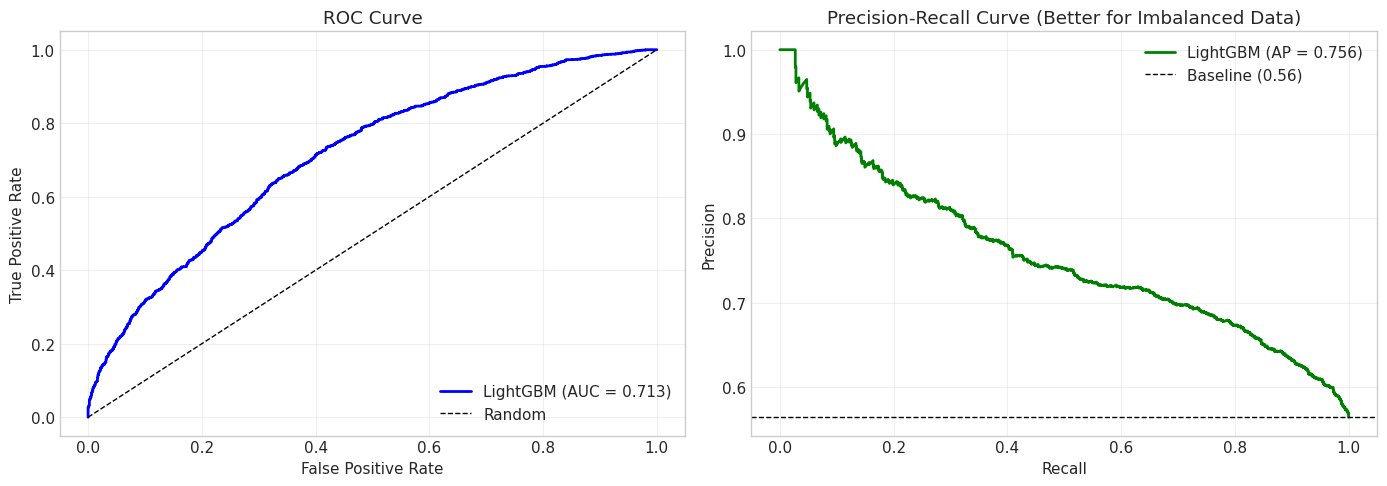

In [22]:
# Visualization: ROC and Precision-Recall curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
ax = axes[0]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'LightGBM (AUC = {auc_roc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# Precision-Recall Curve (better for imbalanced data)
ax = axes[1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ax.plot(recall, precision, 'g-', linewidth=2, label=f'LightGBM (AP = {avg_precision:.3f})')
# Baseline: proportion of positive class
baseline = y_test.mean()
ax.axhline(y=baseline, color='k', linestyle='--', linewidth=1, label=f'Baseline ({baseline:.2f})')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve (Better for Imbalanced Data)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model_evaluation_curves.png', dpi=150, bbox_inches='tight')
plt.show()

Top 25 Most Important Features:
               feature  importance
AVG_PREMIUM_PER_MEMBER          86
       WRITTEN_PREMIUM          75
 QUARTER_CONCENTRATION          73
             Q4_CLAIMS          51
        MAX_EST_AMOUNT          48
             Q3_CLAIMS          47
        EARNED_PREMIUM          47
            LOSS_RATIO          44
      CALLS_PER_MEMBER          43
            MALE_RATIO          43
        AVG_EST_AMOUNT          43
  REGION_CONCENTRATION          42
DIAGNOSES_PER_UTILIZER          40
      UTILIZATION_RATE          35
    PREAUTH_PER_MEMBER          33
   MEMBERS_WITH_CLAIMS          31
        REGION_Central          27
         WEEKDAY_CALLS          27
      TOTAL_EST_AMOUNT          27
   CLAIMS_PER_UTILIZER          25
             Q2_CLAIMS          25
PROVIDERS_PER_UTILIZER          25
     COST_PER_UTILIZER          24
            MALE_COUNT          23
   AVG_RESOLUTION_DAYS          23


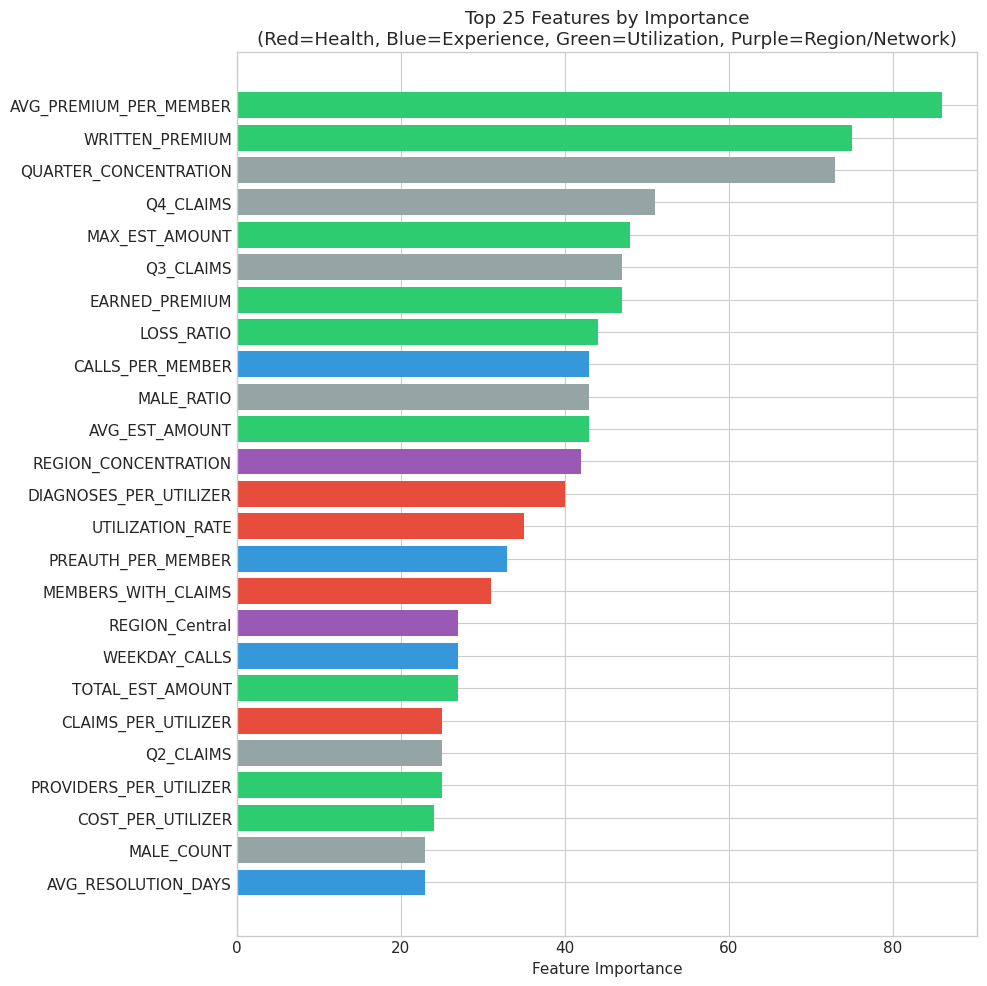

In [23]:
# Feature Importance (built-in LightGBM)
feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print('Top 25 Most Important Features:')
print(feature_importance.head(25).to_string(index=False))

# Plot top 25
fig, ax = plt.subplots(figsize=(10, 10))
top_25 = feature_importance.head(25)
colors = []
for f in top_25['feature']:
    if f in FEATURE_GROUPS['H_HEALTH']:
        colors.append('#e74c3c')  # Red for Health
    elif f in FEATURE_GROUPS['E_EXPERIENCE']:
        colors.append('#3498db')  # Blue for Experience
    elif f in FEATURE_GROUPS['U_UTILIZATION']:
        colors.append('#2ecc71')  # Green for Utilization
    elif f in FEATURE_GROUPS['REGION_NETWORK'] or f.startswith('REGION_') or f.startswith('NETWORK_'):
        colors.append('#9b59b6')  # Purple for Region/Network
    else:
        colors.append('#95a5a6')  # Gray for other

ax.barh(range(len(top_25)), top_25['importance'], color=colors)
ax.set_yticks(range(len(top_25)))
ax.set_yticklabels(top_25['feature'])
ax.invert_yaxis()
ax.set_xlabel('Feature Importance')
ax.set_title('Top 25 Features by Importance\n(Red=Health, Blue=Experience, Green=Utilization, Purple=Region/Network)')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## Phase 2: SHAP Analysis for H, E, U Sub-Scores

Using SHAP values to:
1. Understand feature contributions
2. Decompose IVI into Health (H), Experience (E), Utilization (U) components

In [24]:
print('Computing SHAP values (this may take a few minutes)...')

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values for test set
shap_values = explainer.shap_values(X_test)

# For binary classification, shap_values might be a list [class_0, class_1]
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Use class 1 (retained) SHAP values

print(f'SHAP values shape: {shap_values.shape}')

Computing SHAP values (this may take a few minutes)...
SHAP values shape: (3073, 84)


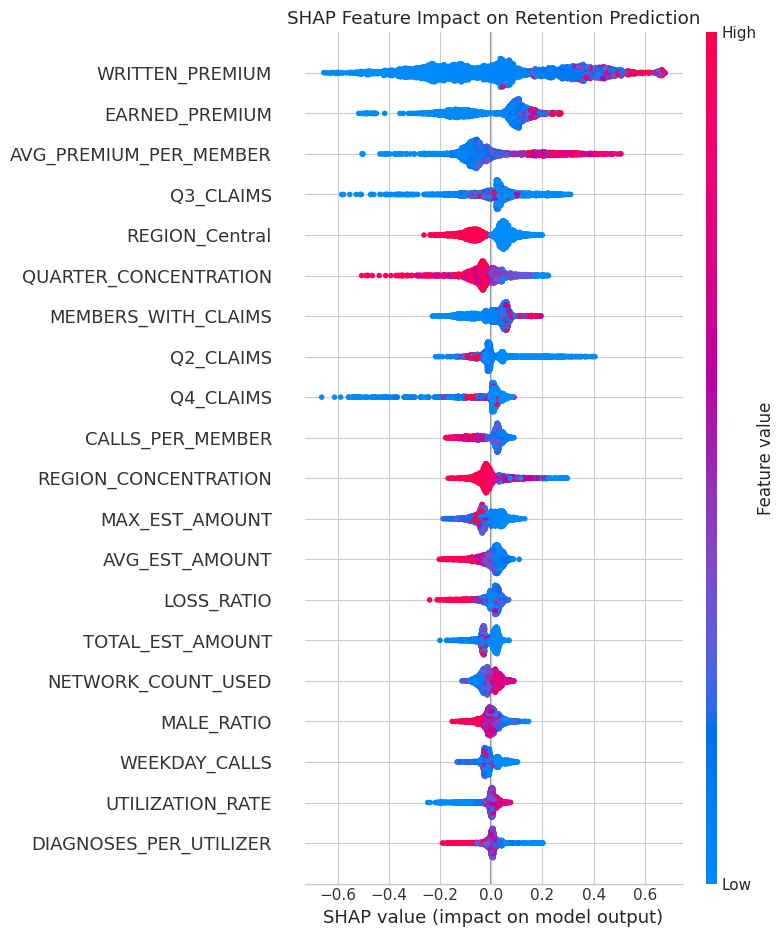

In [25]:
# SHAP Summary Plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test, max_display=20, show=False)
plt.title('SHAP Feature Impact on Retention Prediction')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()

In [26]:
# Decompose SHAP values into H, E, U sub-scores
print('Decomposing SHAP values into H, E, U dimensions...')

# Map feature indices to groups
feature_to_idx = {f: i for i, f in enumerate(available_features)}

# Calculate group contributions
group_shap = {}
for group_name, group_features in FEATURE_GROUPS.items():
    indices = [feature_to_idx[f] for f in group_features if f in feature_to_idx]
    if indices:
        group_shap[group_name] = shap_values[:, indices].sum(axis=1)
    else:
        group_shap[group_name] = np.zeros(len(shap_values))

# Create dataframe with sub-scores
df_shap = pd.DataFrame(group_shap)
df_shap['CONTRACT_NO'] = contracts_test.values
df_shap['IVI_PROBA'] = y_pred_proba
df_shap['ACTUAL'] = y_test.values

# Normalize sub-scores to 0-100 scale
for col in FEATURE_GROUPS.keys():
    min_val = df_shap[col].min()
    max_val = df_shap[col].max()
    if max_val > min_val:
        df_shap[f'{col}_SCORE'] = ((df_shap[col] - min_val) / (max_val - min_val) * 100)
    else:
        df_shap[f'{col}_SCORE'] = 50

# Calculate overall IVI score (0-100)
df_shap['IVI_SCORE'] = df_shap['IVI_PROBA'] * 100

print(f'\nSub-score statistics:')
score_cols = [f'{g}_SCORE' for g in FEATURE_GROUPS.keys()] + ['IVI_SCORE']
print(df_shap[score_cols].describe())

Decomposing SHAP values into H, E, U dimensions...

Sub-score statistics:
       H_HEALTH_SCORE  E_EXPERIENCE_SCORE  U_UTILIZATION_SCORE  \
count     3073.000000         3073.000000          3073.000000   
mean        61.589408           64.352389            59.697305   
std         14.310633           13.505275            15.644914   
min          0.000000            0.000000             0.000000   
25%         54.264419           56.938612            49.658366   
50%         64.861861           66.808471            60.032561   
75%         71.372797           73.062447            69.240759   
max        100.000000          100.000000           100.000000   

       DEMOGRAPHICS_SCORE  SEASONAL_SCORE  PROVIDER_SCORE  \
count         3073.000000     3073.000000     3073.000000   
mean            62.364654       68.114099       22.679901   
std             10.867774        9.766842       13.526437   
min              0.000000        0.000000        0.000000   
25%             55.945678 

In [ ]:
# Aggregate to main H, E, U scores
# H = Health-related SHAP
# E = Experience-related SHAP  
# U = Utilization/Cost-related SHAP

df_shap['H_SCORE'] = df_shap['H_HEALTH_SCORE']
df_shap['E_SCORE'] = df_shap['E_EXPERIENCE_SCORE']
df_shap['U_SCORE'] = df_shap['U_UTILIZATION_SCORE']

print('H, E, U Sub-Scores (0-100):')
print(df_shap[['H_SCORE', 'E_SCORE', 'U_SCORE', 'IVI_SCORE']].describe())

# Compare retained vs churned
print('\nMean scores by retention status:')
print(df_shap.groupby('ACTUAL')[['H_SCORE', 'E_SCORE', 'U_SCORE', 'IVI_SCORE']].mean())

## Phase 3: Business Segmentation

Creating actionable segments based on:
1. IVI Score (model-derived retention probability)
2. Contract characteristics (size, premium, loss ratio)
3. H, E, U decomposition (which dimension is problematic?)

In [16]:
# Generate IVI scores for ALL contract-years
# - 2022 rows have RETAINED_NEXT_YEAR (ground truth)
# - 2023 rows are for forward scoring (no ground truth available)
print('Generating IVI scores for all contract-years...')

# Define KPI definitions and reference data BEFORE using them
# (feature_name, higher_is_better, display_name, description)
KPI_DEFINITIONS = {
    'H': [
        ('UTILIZATION_RATE', False, 'Utilization Rate', 'Members with claims / Total members'),
        ('DIAGNOSES_PER_UTILIZER', False, 'Diagnoses/Utilizer', 'Unique diagnoses per member with claims'),
        ('CLAIMS_PER_UTILIZER', False, 'Claims/Utilizer', 'Claim count per member with claims'),
        ('AVG_CLAIM_AMOUNT', False, 'Avg Claim Amount', 'Average cost per claim'),
        ('P90_CLAIM_AMOUNT', False, 'P90 Claim Amount', '90th percentile claim cost'),
        ('CLAIM_LINES_PER_MEMBER', False, 'Claim Lines/Member', 'Claim line items per member'),
    ],
    'E': [
        ('CALLS_PER_MEMBER', False, 'Calls/Member', 'Customer service calls per member'),
        ('AVG_RESOLUTION_DAYS', False, 'Avg Resolution Days', 'Average days to resolve tickets'),
        ('REJECTION_RATE', False, 'Rejection Rate', 'Pre-auth rejection rate'),
        ('APPROVAL_RATE', True, 'Approval Rate', 'Pre-auth approval rate'),
        ('PREAUTH_PER_MEMBER', False, 'Preauth/Member', 'Pre-auth requests per member'),
    ],
    'U': [
        ('LOSS_RATIO', False, 'Loss Ratio', 'Claims / Written Premium'),
        ('COST_PER_MEMBER', False, 'Cost/Member', 'Total claims / Total members'),
        ('COST_PER_UTILIZER', False, 'Cost/Utilizer', 'Total claims / Members with claims'),
    ],
    'R': [
        ('REGION_COUNT', True, 'Region Coverage', 'Number of regions with claims'),
        ('NETWORK_COUNT_USED', True, 'Network Diversity', 'Number of networks used'),
        ('PRACTICE_TYPE_COUNT', True, 'Practice Types', 'Types of providers used'),
        ('REGION_CONCENTRATION', False, 'Region Concentration', 'Concentration of claims in single region'),
    ],
}

REGION_INFO = {
    'Central': {'major_cities': ['Riyadh'], 'provider_density': 'HIGH', 'population': 'HIGH'},
    'Western': {'major_cities': ['Jeddah', 'Makkah', 'Madinah'], 'provider_density': 'HIGH', 'population': 'HIGH'},
    'Eastern': {'major_cities': ['Dammam', 'Khobar', 'Dhahran'], 'provider_density': 'HIGH', 'population': 'MEDIUM'},
    'Southern': {'major_cities': ['Abha', 'Jizan'], 'provider_density': 'MEDIUM', 'population': 'MEDIUM'},
    'Northern': {'major_cities': ['Tabuk', 'Hail'], 'provider_density': 'LOW', 'population': 'LOW'},
}

NETWORK_TIERS = {
    'NW1': {'tier': 'Premium', 'provider_count': 'HIGH', 'typical_wait': 'LOW'},
    'NW2': {'tier': 'Standard Plus', 'provider_count': 'HIGH', 'typical_wait': 'LOW'},
    'NW3': {'tier': 'Standard', 'provider_count': 'MEDIUM', 'typical_wait': 'MEDIUM'},
    'NW4': {'tier': 'Economy Plus', 'provider_count': 'MEDIUM', 'typical_wait': 'MEDIUM'},
    'NW5': {'tier': 'Economy', 'provider_count': 'LOW', 'typical_wait': 'HIGH'},
    'NW6': {'tier': 'Basic Plus', 'provider_count': 'LOW', 'typical_wait': 'HIGH'},
    'NW7': {'tier': 'Basic', 'provider_count': 'LOW', 'typical_wait': 'HIGH'},
}

# Separate base features from encoded features
base_features = [f for f in available_features if not f.startswith('REGION_') and not f.startswith('NETWORK_')]
encoded_features = [f for f in available_features if f.startswith('REGION_') or f.startswith('NETWORK_')]

base_cols = ['CONTRACT_NO', 'YEAR']
label_col = 'RETAINED_NEXT_YEAR'
cat_cols_all = ['PRIMARY_REGION', 'PRIMARY_NETWORK']

# Select only columns that exist in df
cols_to_select = base_cols + base_features
if label_col in df.columns:
    cols_to_select = cols_to_select + [label_col]
for c in cat_cols_all:
    if c in df.columns:
        cols_to_select.append(c)

# Build a single scoring frame (both years)
df_all = df.select(cols_to_select).to_pandas()

# One-hot encode categorical features (same as training)
if 'PRIMARY_REGION' in df_all.columns:
    df_all['PRIMARY_REGION'] = df_all['PRIMARY_REGION'].fillna('Unknown').astype(str)
    region_dummies_all = pd.get_dummies(df_all['PRIMARY_REGION'], prefix='REGION')
    df_all = pd.concat([df_all, region_dummies_all], axis=1)
    
if 'PRIMARY_NETWORK' in df_all.columns:
    df_all['PRIMARY_NETWORK'] = df_all['PRIMARY_NETWORK'].fillna('Unknown').astype(str)
    network_dummies_all = pd.get_dummies(df_all['PRIMARY_NETWORK'], prefix='NETWORK')
    df_all = pd.concat([df_all, network_dummies_all], axis=1)

# Ensure all features used in training are present (add missing as 0)
for feat in available_features:
    if feat not in df_all.columns:
        df_all[feat] = 0

# Prepare feature matrix
X_all = df_all[available_features].fillna(0)
X_all = X_all.replace([np.inf, -np.inf], 0)

print(f'Scoring {len(df_all):,} contract-years with {len(available_features)} features')

# ============================================================================
# IVI SCORE = ML Retention Probability (0-100)
# The ML model directly predicts retention, which IS the IVI definition
# ============================================================================
ivi_proba_ml = model.predict_proba(X_all)[:, 1]
df_all['IVI_PROBA'] = ivi_proba_ml
df_all['IVI_SCORE'] = ivi_proba_ml * 100  # Direct mapping to 0-100
df_all['IVI_SCORE_ML'] = ivi_proba_ml * 100  # Alias for compatibility

# ============================================================================
# H/E/U DIMENSION SCORES (for explainability, NOT aggregated into IVI)
# These show the "health index" interpretation where lower costs = better health
# Note: These are INVERSELY correlated with retention (engaged clients stay!)
# ============================================================================
train_mask = df_all['YEAR'].astype(str) == '2022'

def _ecdf_percentile(train_values: np.ndarray, values: np.ndarray) -> np.ndarray:
    """Compute ECDF-based percentile for values based on training distribution."""
    train = np.asarray(train_values, dtype=float)
    train = train[~np.isnan(train)]
    v = np.asarray(values, dtype=float)
    if train.size == 0:
        return np.full(v.shape, 0.5, dtype=float)
    train_sorted = np.sort(train)
    return np.searchsorted(train_sorted, v, side='right') / train_sorted.size

def _feature_score(feature: str, higher_is_better: bool) -> np.ndarray | None:
    """Convert feature to 0-1 score where 1 is always 'better' for health."""
    if feature not in df_all.columns:
        return None
    p = _ecdf_percentile(df_all.loc[train_mask, feature], df_all[feature])
    if not higher_is_better:
        p = 1.0 - p  # Invert: low value = high health score
    return np.clip(p, 0.0, 1.0)

# Feature definitions for health index: (feature, higher_is_better_for_health)
RULE_FEATURES: dict[str, list[tuple[str, bool]]] = {
    'H': [  # Health dimension: lower medical need = healthier
        ('UTILIZATION_RATE', False),
        ('DIAGNOSES_PER_UTILIZER', False),
        ('CLAIMS_PER_UTILIZER', False),
        ('AVG_CLAIM_AMOUNT', False),
        ('P90_CLAIM_AMOUNT', False),
        ('CLAIM_LINES_PER_MEMBER', False),
    ],
    'E': [  # Experience dimension: fewer issues = better experience
        ('CALLS_PER_MEMBER', False),
        ('AVG_RESOLUTION_DAYS', False),
        ('REJECTION_RATE', False),
        ('APPROVAL_RATE', True),
        ('PREAUTH_PER_MEMBER', False),
    ],
    'U': [  # Utilization dimension: lower costs = more sustainable
        ('LOSS_RATIO', False),
        ('COST_PER_MEMBER', False),
        ('COST_PER_UTILIZER', False),
    ],
}

# Calculate dimension scores
dim_scores: dict[str, np.ndarray] = {}
for dim, feats in RULE_FEATURES.items():
    parts: list[np.ndarray] = []
    for feat, higher_is_better in feats:
        s = _feature_score(feat, higher_is_better)
        if s is not None:
            parts.append(s)

    if not parts:
        dim_scores[dim] = np.full(len(df_all), 0.5, dtype=float)
        continue

    mat = np.vstack(parts).T
    dim_scores[dim] = mat.mean(axis=1)

# Dimension scores (0-100) - these are health/efficiency indicators
df_all['H_SCORE_RULE'] = dim_scores['H'] * 100
df_all['E_SCORE_RULE'] = dim_scores['E'] * 100
df_all['U_SCORE_RULE'] = dim_scores['U'] * 100

# Weights for reference (not used in IVI calculation)
weights_heu = {'H': 0.30, 'E': 0.30, 'U': 0.40}

# Calculate combined rule-based score (for reference)
df_all['IVI_SCORE_RULE'] = (
    weights_heu['H'] * df_all['H_SCORE_RULE'] +
    weights_heu['E'] * df_all['E_SCORE_RULE'] +
    weights_heu['U'] * df_all['U_SCORE_RULE']
)

# Non-linear aggregation for rule score
df_all['IVI_SCORE_RULE_NL'] = (
    (df_all['H_SCORE_RULE'] ** 0.5) *
    (df_all['E_SCORE_RULE'] ** 0.5) *
    (df_all['U_SCORE_RULE'] ** 0.5)
) ** (1/3) * 10  # Scale to 0-100

# Build datasets
if label_col in df_all.columns:
    df_all['RETAINED_ACTUAL'] = df_all[label_col]
else:
    df_all['RETAINED_ACTUAL'] = np.nan

# ============================================================================
# SEGMENTATION: Create IVI_RISK and SEGMENT columns
# ============================================================================
# IVI Risk based on score thresholds
def assign_ivi_risk(score):
    if score < 30:
        return 'HIGH_RISK'
    elif score < 60:
        return 'MODERATE_RISK'
    else:
        return 'LOW_RISK'

df_all['IVI_RISK'] = df_all['IVI_SCORE'].apply(assign_ivi_risk)

# Contract size classification
def classify_size(members):
    if members >= 100:
        return 'LARGE'
    else:
        return 'SMALL'

df_all['SIZE_CLASS'] = df_all['TOTAL_MEMBERS'].apply(classify_size) if 'TOTAL_MEMBERS' in df_all.columns else 'UNKNOWN'

# Profitability classification
def classify_profitability(lr):
    if pd.isna(lr) or lr < 0.85:
        return 'PROFITABLE'
    else:
        return 'UNPROFITABLE'

df_all['PROFIT_CLASS'] = df_all['LOSS_RATIO'].apply(classify_profitability) if 'LOSS_RATIO' in df_all.columns else 'UNKNOWN'

# Combined segment
df_all['SEGMENT'] = df_all['IVI_RISK'] + '_' + df_all['SIZE_CLASS'] + '_' + df_all['PROFIT_CLASS']

# Create subsets for different years
df_ivi_all = df_all.copy()
df_ivi = df_ivi_all[df_ivi_all['YEAR'].astype(str) == '2022'].copy()
df_ivi_2023 = df_ivi_all[df_ivi_all['YEAR'].astype(str) == '2023'].copy()

print(f'IVI scores generated for {len(df_ivi):,} (2022) labelled contracts')
print(f'Forward scores generated for {len(df_ivi_2023):,} (2023) contracts')

print('\nIVI Score Distribution (2022):')
print(df_ivi['IVI_SCORE'].describe())

print('\nDimension Health Scores (higher = healthier/more efficient):')
print(df_ivi[['H_SCORE_RULE', 'E_SCORE_RULE', 'U_SCORE_RULE']].describe())

print('\nIVI Risk Distribution (2022):')
print(df_ivi['IVI_RISK'].value_counts())

# Correlation check
print('\nCorrelation with Retention (2022):')
print(f'  IVI_SCORE: {df_ivi["IVI_SCORE"].corr(df_ivi["RETAINED_ACTUAL"]):.4f}')
print(f'  (Note: H/E/U health scores are inversely correlated - engaged clients stay longer)')

Generating IVI scores for all contract-years...
Scoring 31,346 contract-years with 84 features
IVI scores generated for 15,364 (2022) labelled contracts
Forward scores generated for 15,982 (2023) contracts

IVI Score Distribution (2022):
count    15364.000000
mean        52.614016
std         15.053231
min          9.468746
25%         42.268077
50%         52.659080
75%         62.139938
max         90.821223
Name: IVI_SCORE, dtype: float64

Dimension Health Scores (higher = healthier/more efficient):
       H_SCORE_RULE  E_SCORE_RULE  U_SCORE_RULE
count  15364.000000  15364.000000  15364.000000
mean      49.649821     48.369156     49.752899
std       22.262480     16.318231     27.263085
min        0.647618      5.152304      0.026095
25%       32.616289     36.483012     26.535567
50%       47.912328     47.597631     49.142857
75%       64.869988     59.981450     72.952842
max       93.709320     90.178339     93.784528

IVI Risk Distribution (2022):
IVI_RISK
MODERATE_RISK    985

In [ ]:
# Diagnose rule score issue - check correlation direction
print('Diagnosing Rule Score vs Retention Relationship')
print('=' * 60)

# Check individual dimension correlations
for dim in ['H', 'E', 'U']:
    col = f'{dim}_SCORE_RULE'
    if col in df_ivi.columns:
        corr = df_ivi[col].corr(df_ivi['RETAINED_ACTUAL'])
        print(f'{col} correlation with retention: {corr:.4f}')

# Check underlying KPI correlations
print('\nUnderlying KPI correlations with retention:')
for feat, higher_is_better in [('LOSS_RATIO', False), ('UTILIZATION_RATE', False), ('CALLS_PER_MEMBER', False)]:
    if feat in df_ivi.columns:
        corr = df_ivi[feat].corr(df_ivi['RETAINED_ACTUAL'])
        print(f'  {feat}: {corr:.4f} (expected: {"positive" if higher_is_better else "negative"})')

# The issue: contracts with LOW utilization/costs are RETAINED more often
# But our "score" gives high scores to low values, which should mean high score = good = retained
# Let's verify
print('\nMean values by retention status:')
score_cols = ['H_SCORE_RULE', 'E_SCORE_RULE', 'U_SCORE_RULE', 'IVI_SCORE_RULE']
available_score_cols = [c for c in score_cols if c in df_ivi.columns]
print(df_ivi.groupby('RETAINED_ACTUAL')[available_score_cols].mean())

In [ ]:
# Validate segments: Do they predict retention well?
print('Segment Validation: Actual Retention Rates')
print('=' * 60)

# Check if required columns exist
if 'IVI_RISK' not in df_ivi.columns:
    print('ERROR: IVI_RISK column not found. Please run the IVI scoring cell first.')
else:
    # By IVI Risk only
    print('\n1. By IVI Risk Category:')
    ivi_validation = df_ivi.groupby('IVI_RISK').agg({
        'CONTRACT_NO': 'count',
        'RETAINED_ACTUAL': ['sum', 'mean'],
        'IVI_SCORE': 'mean',
        'LOSS_RATIO': 'mean',
        'TOTAL_MEMBERS': 'mean',
    }).round(3)
    ivi_validation.columns = ['Count', 'Retained', 'Retention_Rate', 'Avg_IVI', 'Avg_Loss_Ratio', 'Avg_Members']
    print(ivi_validation)

    # Check if segments make business sense
    print('\n2. Key Insight Check:')
    for risk in ['HIGH_RISK', 'MODERATE_RISK', 'LOW_RISK']:
        subset = df_ivi[df_ivi['IVI_RISK'] == risk]
        if len(subset) > 0:
            retention = subset['RETAINED_ACTUAL'].mean() * 100
            avg_ivi = subset['IVI_SCORE'].mean()
            print(f'  {risk}: IVI={avg_ivi:.1f}, Actual Retention={retention:.1f}%')

In [ ]:
df_ivi['IVI_SCORE'].hist()

In [ ]:
# Detailed segment analysis
if 'SEGMENT' not in df_ivi.columns:
    print('ERROR: SEGMENT column not found. Please run the IVI scoring cell first.')
else:
    print('\n3. By Combined Segment (Top 10):')
    segment_analysis = df_ivi.groupby('SEGMENT').agg({
        'CONTRACT_NO': 'count',
        'RETAINED_ACTUAL': 'mean',
        'IVI_SCORE': 'mean',
        'LOSS_RATIO': 'mean',
        'EARNED_PREMIUM': 'sum',
        'TOTAL_BILLED': 'sum',
    }).round(3)
    segment_analysis.columns = ['Count', 'Retention_Rate', 'Avg_IVI', 'Avg_Loss_Ratio', 'Total_Premium', 'Total_Claims']
    segment_analysis = segment_analysis.sort_values('Retention_Rate', ascending=True)
    print(segment_analysis.head(10))

In [ ]:
# Visualization: Segment comparison
if 'IVI_RISK' not in df_ivi.columns:
    print('ERROR: IVI_RISK column not found. Please run the IVI scoring cell first.')
else:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. IVI Score Distribution by Risk Category
    ax = axes[0, 0]
    for risk, color in [('HIGH_RISK', 'red'), ('MODERATE_RISK', 'orange'), ('LOW_RISK', 'green')]:
        subset = df_ivi[df_ivi['IVI_RISK'] == risk]['IVI_SCORE']
        if len(subset) > 0:
            ax.hist(subset, bins=30, alpha=0.5, label=risk, color=color)
    ax.set_xlabel('IVI Score')
    ax.set_ylabel('Frequency')
    ax.set_title('IVI Score Distribution by Risk Category')
    ax.legend()

    # 2. Retention Rate by Segment
    ax = axes[0, 1]
    retention_by_risk = df_ivi.groupby('IVI_RISK')['RETAINED_ACTUAL'].mean().sort_values()
    colors = ['red' if 'HIGH' in x else 'orange' if 'MODERATE' in x else 'green' for x in retention_by_risk.index]
    ax.barh(retention_by_risk.index, retention_by_risk.values, color=colors)
    ax.set_xlabel('Retention Rate')
    ax.set_title('Actual Retention Rate by IVI Risk Category')
    for i, v in enumerate(retention_by_risk.values):
        ax.text(v + 0.01, i, f'{v:.1%}', va='center')

    # 3. IVI Score vs Loss Ratio
    ax = axes[1, 0]
    scatter = ax.scatter(
        df_ivi['LOSS_RATIO'].clip(upper=3), 
        df_ivi['IVI_SCORE'],
        c=df_ivi['RETAINED_ACTUAL'],
        cmap='RdYlGn',
        alpha=0.5,
        s=10
    )
    ax.axvline(x=1.0, color='red', linestyle='--', label='Break-even')
    ax.set_xlabel('Loss Ratio (capped at 3)')
    ax.set_ylabel('IVI Score')
    ax.set_title('IVI Score vs Loss Ratio (Green=Retained)')
    ax.legend()

    # 4. Contract Size vs IVI Score
    ax = axes[1, 1]
    ax.scatter(
        df_ivi['TOTAL_MEMBERS'].clip(upper=df_ivi['TOTAL_MEMBERS'].quantile(0.99)),
        df_ivi['IVI_SCORE'],
        c=df_ivi['RETAINED_ACTUAL'],
        cmap='RdYlGn',
        alpha=0.5,
        s=10
    )
    ax.set_xlabel('Total Members (capped at 99th percentile)')
    ax.set_ylabel('IVI Score')
    ax.set_title('Contract Size vs IVI Score (Green=Retained)')

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'segment_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

## Model Validation: Does Segmentation Make Business Sense?

In [ ]:
# Comprehensive validation
print('MODEL VALIDATION SUMMARY')
print('=' * 60)

# 1. Does IVI Score correlate with retention?
correlation = df_ivi['IVI_SCORE'].corr(df_ivi['RETAINED_ACTUAL'])
print(f'\n1. IVI Score correlation with retention: {correlation:.3f}')

# 2. Are high-risk segments actually churning more?
print('\n2. Retention by Risk Category:')
for risk in ['LOW_RISK', 'MODERATE_RISK', 'HIGH_RISK']:
    subset = df_ivi[df_ivi['IVI_RISK'] == risk]
    n = len(subset)
    retained = subset['RETAINED_ACTUAL'].sum()
    rate = subset['RETAINED_ACTUAL'].mean()
    print(f'   {risk}: {retained:,}/{n:,} retained ({rate:.1%})')

# 3. Is the model better than baseline?
baseline_retention = df_ivi['RETAINED_ACTUAL'].mean()
print(f'\n3. Baseline retention rate: {baseline_retention:.1%}')
print(f'   If we target HIGH_RISK for intervention:')
high_risk = df_ivi[df_ivi['IVI_RISK'] == 'HIGH_RISK']
high_risk_churn = (1 - high_risk['RETAINED_ACTUAL'].mean())
print(f'   - We correctly identify {high_risk_churn:.1%} churn rate in this group')

# 4. Lift analysis
print('\n4. Lift Analysis (targeting top 20% by risk):')
df_ivi_sorted = df_ivi.sort_values('IVI_SCORE', ascending=True)
top_20_pct = df_ivi_sorted.head(int(len(df_ivi) * 0.2))
top_20_churn = 1 - top_20_pct['RETAINED_ACTUAL'].mean()
overall_churn = 1 - df_ivi['RETAINED_ACTUAL'].mean()
lift = top_20_churn / overall_churn
print(f'   - Overall churn rate: {overall_churn:.1%}')
print(f'   - Top 20% risk churn rate: {top_20_churn:.1%}')
print(f'   - Lift: {lift:.2f}x')

In [ ]:
# Business recommendations by segment
print('\nBUSINESS RECOMMENDATIONS BY SEGMENT')
print('=' * 60)

recommendations = {
    'HIGH_RISK_LARGE_UNPROFITABLE': {
        'priority': 'CRITICAL',
        'action': 'Immediate relationship manager intervention. Review pricing, benefits design. Consider wellness programs.',
        'risk': 'High revenue at risk with poor economics',
    },
    'HIGH_RISK_LARGE_PROFITABLE': {
        'priority': 'HIGH',
        'action': 'Proactive engagement to understand dissatisfaction. Service quality review.',
        'risk': 'Profitable account at churn risk - protect relationship',
    },
    'HIGH_RISK_SMALL_UNPROFITABLE': {
        'priority': 'MEDIUM',
        'action': 'Automated retention campaigns. Consider pricing adjustment at renewal.',
        'risk': 'Volume matters - standardized intervention',
    },
    'MODERATE_RISK_LARGE_UNPROFITABLE': {
        'priority': 'HIGH',
        'action': 'Cost containment programs. Utilization management review.',
        'risk': 'Economics need fixing before relationship deteriorates',
    },
    'LOW_RISK_LARGE_PROFITABLE': {
        'priority': 'MAINTAIN',
        'action': 'Maintain relationship. Consider upselling additional services.',
        'risk': 'Low - nurture and grow',
    },
}

for segment, rec in recommendations.items():
    count = len(df_ivi[df_ivi['SEGMENT'] == segment])
    if count > 0:
        print(f'\n{segment} ({count:,} contracts)')
        print(f'  Priority: {rec["priority"]}')
        print(f'  Action: {rec["action"]}')
        print(f'  Risk: {rec["risk"]}')

## Save Outputs

In [ ]:
# Save model and results
print('Saving outputs...')
print('=' * 60)

import joblib

# 1. Save model bundle (model + metadata)
bundle = {
    'model': model,
    'best_threshold': float(best_threshold),
    'features': available_features,
    'feature_groups': FEATURE_GROUPS,
    'weights_heu': weights_heu,  # IVI dimension weights
}

# Add optional items if they exist
if 'REGION_INFO' in globals():
    bundle['region_info'] = REGION_INFO
if 'NETWORK_TIERS' in globals():
    bundle['network_tiers'] = NETWORK_TIERS
if 'KPI_DEFINITIONS' in globals():
    bundle['kpi_definitions'] = KPI_DEFINITIONS
if 'RULE_FEATURES' in globals():
    bundle['rule_features'] = RULE_FEATURES

joblib.dump(bundle, OUTPUT_DIR / 'ivi_model_bundle.joblib')
print(f'[1] Model bundle saved: {OUTPUT_DIR / "ivi_model_bundle.joblib"}')

# 2. Save IVI scores and segments (2022 labelled)
df_ivi.to_parquet(OUTPUT_DIR / 'ivi_scores_segments_2022.parquet', index=False)
print(f'[2] IVI scores saved: {OUTPUT_DIR / "ivi_scores_segments_2022.parquet"}')

# 3. Save forward scores (2023)
if 'df_ivi_2023' in globals() and len(df_ivi_2023) > 0:
    df_ivi_2023.to_parquet(OUTPUT_DIR / 'ivi_scores_forward_2023.parquet', index=False)
    print(f'[3] Forward scores saved: {OUTPUT_DIR / "ivi_scores_forward_2023.parquet"}')

# 4. Save all-years scores
if 'df_ivi_all' in globals() and len(df_ivi_all) > 0:
    df_ivi_all.to_parquet(OUTPUT_DIR / 'ivi_scores_all_years.parquet', index=False)
    print(f'[4] All-years scores saved: {OUTPUT_DIR / "ivi_scores_all_years.parquet"}')

# 5. Save feature importance
feature_importance.to_csv(OUTPUT_DIR / 'feature_importance.csv', index=False)
print(f'[5] Feature importance saved: {OUTPUT_DIR / "feature_importance.csv"}')

# 6. Save SHAP sub-scores if available
if 'df_shap' in globals():
    df_shap.to_parquet(OUTPUT_DIR / 'shap_subscores.parquet', index=False)
    print(f'[6] SHAP sub-scores saved: {OUTPUT_DIR / "shap_subscores.parquet"}')

print('\nAll outputs saved successfully!')

In [ ]:
# Final summary
print('\n' + '=' * 60)
print('IVI MODEL SUMMARY')
print('=' * 60)

# Get counts safely
high_risk_count = len(df_ivi[df_ivi['IVI_RISK'] == 'HIGH_RISK']) if 'IVI_RISK' in df_ivi.columns else 0
mod_risk_count = len(df_ivi[df_ivi['IVI_RISK'] == 'MODERATE_RISK']) if 'IVI_RISK' in df_ivi.columns else 0
low_risk_count = len(df_ivi[df_ivi['IVI_RISK'] == 'LOW_RISK']) if 'IVI_RISK' in df_ivi.columns else 0

# Get retention rates safely
hr_retention = df_ivi[df_ivi['IVI_RISK'] == 'HIGH_RISK']['RETAINED_ACTUAL'].mean() if high_risk_count > 0 else 0
lr_retention = df_ivi[df_ivi['IVI_RISK'] == 'LOW_RISK']['RETAINED_ACTUAL'].mean() if low_risk_count > 0 else 0

# Calculate lift if not already defined
if 'lift' not in globals():
    df_ivi_sorted = df_ivi.sort_values('IVI_SCORE', ascending=True)
    top_20_pct = df_ivi_sorted.head(int(len(df_ivi) * 0.2))
    top_20_churn = 1 - top_20_pct['RETAINED_ACTUAL'].mean()
    overall_churn = 1 - df_ivi['RETAINED_ACTUAL'].mean()
    lift = top_20_churn / overall_churn if overall_churn > 0 else 1.0

print(f'''
Model Performance:
  - AUC-ROC: {auc_roc:.3f}
  - Average Precision: {avg_precision:.3f}
  - F1-Score: {f1:.3f}

IVI Score Range: {df_ivi['IVI_SCORE'].min():.1f} - {df_ivi['IVI_SCORE'].max():.1f}

IVI Score Composition:
  - ML Retention Score: Direct probability from LightGBM
  - Rule-Based Score: Weighted avg of H ({weights_heu['H']:.0%}), E ({weights_heu['E']:.0%}), U ({weights_heu['U']:.0%})

Risk Segmentation:
  - HIGH_RISK:     {high_risk_count:,} contracts
  - MODERATE_RISK: {mod_risk_count:,} contracts  
  - LOW_RISK:      {low_risk_count:,} contracts

Top 5 Predictive Features:
''')
for i, row in feature_importance.head(5).iterrows():
    print(f'  {i+1}. {row["feature"]}: {row["importance"]:.0f}')

print(f'''
Validation:
  - HIGH_RISK actual retention: {hr_retention:.1%}
  - LOW_RISK actual retention:  {lr_retention:.1%}
  - Lift (top 20%): {lift:.2f}x

Region/Network Features Included:
  - REGION_COUNT, NETWORK_COUNT_USED, PRACTICE_TYPE_COUNT, REGION_CONCENTRATION
  - PRIMARY_REGION (one-hot encoded)
  - PRIMARY_NETWORK (one-hot encoded)
''')

## Case-by-Case Client Analysis: Why Did They Get Their Score?

This section drills into specific clients from each risk tier to understand:
1. What KPIs drove their H, E, U sub-scores
2. How the non-linear aggregation affected their final IVI
3. Whether the score makes business sense

In [ ]:
# KPI_DEFINITIONS, REGION_INFO, NETWORK_TIERS are already defined in the IVI scoring cell above
# This cell sets up helper functions for percentile calculations

# Helper function to get percentile rank of a value within 2022 distribution
def get_percentile_rank(feature: str, value: float, df_ref: pd.DataFrame) -> float:
    """Return the percentile rank (0-100) of value within df_ref[feature]."""
    if feature not in df_ref.columns:
        return 50.0
    ref_vals = df_ref[feature].dropna().values
    if len(ref_vals) == 0:
        return 50.0
    return float(np.searchsorted(np.sort(ref_vals), value, side='right') / len(ref_vals) * 100)

# Build reference dataframe (2022 only) for percentile calculations
df_ref = df_ivi.copy()

print(f'Reference population: {len(df_ref):,} contracts (2022)')
print(f'\nRisk tier distribution:')
if 'IVI_RISK' in df_ivi.columns:
    print(df_ivi['IVI_RISK'].value_counts())
else:
    print('IVI_RISK column not found - run IVI scoring cell first')

# Show region/network statistics
print('\nRegion/Network Statistics (2022):')
region_cols = ['REGION_COUNT', 'NETWORK_COUNT_USED', 'PRACTICE_TYPE_COUNT', 'REGION_CONCENTRATION']
for col in region_cols:
    if col in df_ivi.columns:
        print(f'  {col}: mean={df_ivi[col].mean():.2f}, median={df_ivi[col].median():.2f}')

In [ ]:
# Select sample clients from each risk tier
# Pick clients near the median IVI within each tier (representative examples)
np.random.seed(42)

sample_clients = {}
for risk_tier in ['HIGH_RISK', 'MODERATE_RISK', 'LOW_RISK']:
    tier_df = df_ivi[df_ivi['IVI_RISK'] == risk_tier].copy()
    if len(tier_df) == 0:
        continue
    # Pick 3 clients: one near 25th, 50th, and 75th percentile within the tier
    tier_df_sorted = tier_df.sort_values('IVI_SCORE')
    n = len(tier_df_sorted)
    indices = [int(n * 0.25), int(n * 0.5), int(n * 0.75)]
    sample_clients[risk_tier] = tier_df_sorted.iloc[indices]['CONTRACT_NO'].tolist()

print('Sample Clients Selected:')
for tier, contracts in sample_clients.items():
    print(f'\n{tier}:')
    for c in contracts:
        row = df_ivi[df_ivi['CONTRACT_NO'] == c].iloc[0]
        print(f'  {c}: IVI={row["IVI_SCORE"]:.1f}, H={row.get("H_SCORE_RULE", "N/A"):.1f}, '
              f'E={row.get("E_SCORE_RULE", "N/A"):.1f}, U={row.get("U_SCORE_RULE", "N/A"):.1f}')

In [ ]:
def analyze_client(contract_no: str, df_scores: pd.DataFrame, df_ref: pd.DataFrame):
    """
    Generate a detailed analysis of why a client received their IVI score.
    Returns a dict with all the breakdown info including region/network insights.
    """
    if contract_no not in df_scores['CONTRACT_NO'].values:
        return None
    
    row = df_scores[df_scores['CONTRACT_NO'] == contract_no].iloc[0]
    
    analysis = {
        'contract_no': contract_no,
        'ivi_score': row.get('IVI_SCORE', None),
        'ivi_score_ml': row.get('IVI_SCORE_ML', row.get('IVI_SCORE', None)),
        'ivi_score_rule': row.get('IVI_SCORE_RULE', None),
        'ivi_risk': row.get('IVI_RISK', None),
        'retained_actual': row.get('RETAINED_ACTUAL', None),
        'h_score': row.get('H_SCORE_RULE', None),
        'e_score': row.get('E_SCORE_RULE', None),
        'u_score': row.get('U_SCORE_RULE', None),
        'dimensions': {},
        'key_metrics': {},
        'region_network': {},
    }
    
    # Analyze each dimension (H, E, U, R)
    for dim, kpis in KPI_DEFINITIONS.items():
        dim_name = {'H': 'Health', 'E': 'Experience', 'U': 'Utilization', 'R': 'Region/Network'}[dim]
        dim_analysis = []
        
        for feat, higher_is_better, display_name, desc in kpis:
            if feat not in row.index:
                continue
            
            val = row[feat]
            if pd.isna(val):
                continue
            
            pct = get_percentile_rank(feat, val, df_ref)
            
            # Score contribution: if higher is better, high percentile = good
            # if lower is better, low percentile = good
            if higher_is_better:
                score_contribution = pct  # High value = high score
                interpretation = 'higher is better'
            else:
                score_contribution = 100 - pct  # Low value = high score
                interpretation = 'lower is better'
            
            # Determine if this KPI is helping or hurting
            if score_contribution >= 70:
                impact = 'STRONG'
            elif score_contribution >= 50:
                impact = 'NEUTRAL'
            elif score_contribution >= 30:
                impact = 'WEAK'
            else:
                impact = 'CRITICAL'
            
            dim_analysis.append({
                'feature': feat,
                'display_name': display_name,
                'description': desc,
                'value': val,
                'percentile': pct,
                'score_contribution': score_contribution,
                'interpretation': interpretation,
                'impact': impact,
            })
        
        analysis['dimensions'][dim] = {
            'name': dim_name,
            'score': row.get(f'{dim}_SCORE_RULE', None) if dim != 'R' else None,
            'kpis': dim_analysis,
        }
    
    # Add key business metrics
    for col in ['TOTAL_MEMBERS', 'WRITTEN_PREMIUM', 'TOTAL_BILLED', 'LOSS_RATIO', 
                'TOTAL_CALLS', 'UTILIZATION_RATE']:
        if col in row.index:
            analysis['key_metrics'][col] = row[col]
    
    # Add region/network context
    if 'PRIMARY_REGION' in row.index and pd.notna(row['PRIMARY_REGION']):
        primary_region = str(row['PRIMARY_REGION'])
        analysis['region_network']['primary_region'] = primary_region
        if primary_region in REGION_INFO:
            analysis['region_network']['region_info'] = REGION_INFO[primary_region]
    
    if 'PRIMARY_NETWORK' in row.index and pd.notna(row['PRIMARY_NETWORK']):
        primary_network = str(row['PRIMARY_NETWORK'])
        analysis['region_network']['primary_network'] = primary_network
        if primary_network in NETWORK_TIERS:
            analysis['region_network']['network_info'] = NETWORK_TIERS[primary_network]
    
    if 'REGION_COUNT' in row.index:
        analysis['region_network']['region_count'] = row['REGION_COUNT']
    if 'NETWORK_COUNT_USED' in row.index:
        analysis['region_network']['network_count'] = row['NETWORK_COUNT_USED']
    if 'REGION_CONCENTRATION' in row.index:
        analysis['region_network']['region_concentration'] = row['REGION_CONCENTRATION']
    
    return analysis


def get_region_network_insights(analysis: dict) -> list[str]:
    """Generate actionable insights based on region/network patterns."""
    insights = []
    rn = analysis.get('region_network', {})
    
    # Check region coverage
    region_count = rn.get('region_count', 0)
    if region_count == 1:
        insights.append('Single-region client: May face access issues if employees relocate or travel')
    elif region_count >= 4:
        insights.append('Multi-region client: Ensure consistent service quality across all regions')
    
    # Check network tier
    network_info = rn.get('network_info', {})
    network_tier = network_info.get('tier', '')
    if network_tier in ['Basic', 'Basic Plus', 'Economy']:
        insights.append(f'Lower-tier network ({network_tier}): Limited provider options may cause delays/rejections')
    
    # Check region density
    region_info = rn.get('region_info', {})
    provider_density = region_info.get('provider_density', '')
    if provider_density == 'LOW':
        insights.append('Low provider density region: Consider expanded network or telemedicine options')
    
    # Check concentration
    concentration = rn.get('region_concentration', 0)
    if concentration > 0.9:
        insights.append('Highly concentrated in single region: Business continuity risk if regional issues occur')
    
    return insights


def print_client_analysis(analysis: dict):
    """Pretty-print a client analysis with region/network insights."""
    print('=' * 80)
    print(f'CONTRACT: {analysis["contract_no"]}')
    print('=' * 80)
    
    print(f'\n--- SCORES ---')
    ivi_score = analysis.get("ivi_score", 0)
    ivi_ml = analysis.get("ivi_score_ml", ivi_score)
    ivi_rule = analysis.get("ivi_score_rule", 0)
    
    print(f'  Final IVI Score:       {ivi_score:.1f}' if ivi_score else '  Final IVI Score: N/A')
    print(f'  ML Retention Score:    {ivi_ml:.1f}' if ivi_ml else '  ML Retention Score: N/A')
    print(f'  Rule-Based Score:      {ivi_rule:.1f}' if ivi_rule else '  Rule-Based Score: N/A')
    print(f'  Risk Tier:             {analysis.get("ivi_risk", "N/A")}')
    
    retained = analysis.get("retained_actual")
    if pd.notna(retained):
        print(f'  Actual Outcome:        {"RETAINED" if retained == 1 else "CHURNED"}')
    
    h_score = analysis.get("h_score", 0)
    e_score = analysis.get("e_score", 0)
    u_score = analysis.get("u_score", 0)
    
    print(f'\n--- DIMENSION SCORES (0-100, higher = better) ---')
    print(f'  H (Health):      {h_score:.1f}' if h_score else '  H (Health): N/A')
    print(f'  E (Experience):  {e_score:.1f}' if e_score else '  E (Experience): N/A')
    print(f'  U (Utilization): {u_score:.1f}' if u_score else '  U (Utilization): N/A')
    
    # Find the weakest dimension
    scores = {'H': h_score or 50, 'E': e_score or 50, 'U': u_score or 50}
    weakest = min(scores, key=scores.get)
    print(f'\n  >> Weakest Dimension: {weakest} ({scores[weakest]:.1f})')
    
    # Region/Network info
    rn = analysis.get('region_network', {})
    if rn:
        print(f'\n--- REGION/NETWORK PROFILE ---')
        if 'primary_region' in rn:
            print(f'  Primary Region:  {rn["primary_region"]}')
            if 'region_info' in rn:
                ri = rn['region_info']
                print(f'    - Provider Density: {ri.get("provider_density", "N/A")}')
                print(f'    - Major Cities: {", ".join(ri.get("major_cities", []))}')
        if 'primary_network' in rn:
            print(f'  Primary Network: {rn["primary_network"]}')
            if 'network_info' in rn:
                ni = rn['network_info']
                print(f'    - Tier: {ni.get("tier", "N/A")}')
                print(f'    - Provider Count: {ni.get("provider_count", "N/A")}')
        if 'region_count' in rn:
            print(f'  Regions Used:    {rn["region_count"]:.0f}')
        if 'network_count' in rn:
            print(f'  Networks Used:   {rn["network_count"]:.0f}')
        if 'region_concentration' in rn:
            print(f'  Regional Concentration: {rn["region_concentration"]:.1%}')
        
        # Region/Network insights
        insights = get_region_network_insights(analysis)
        if insights:
            print(f'\n  >> Regional Insights:')
            for insight in insights:
                print(f'     - {insight}')
    
    print(f'\n--- KEY BUSINESS METRICS ---')
    km = analysis.get('key_metrics', {})
    if 'TOTAL_MEMBERS' in km:
        print(f'  Members:        {km["TOTAL_MEMBERS"]:,.0f}')
    if 'WRITTEN_PREMIUM' in km:
        print(f'  Written Premium: {km["WRITTEN_PREMIUM"]:,.0f}')
    if 'TOTAL_BILLED' in km:
        print(f'  Total Claims:    {km["TOTAL_BILLED"]:,.0f}')
    if 'LOSS_RATIO' in km:
        lr = km['LOSS_RATIO']
        lr_status = 'OK' if lr < 0.85 else ('BORDERLINE' if lr < 1.0 else 'UNPROFITABLE')
        print(f'  Loss Ratio:      {lr:.2%} ({lr_status})')
    
    print(f'\n--- KPI BREAKDOWN BY DIMENSION ---')
    for dim_key in ['H', 'E', 'U', 'R']:
        if dim_key not in analysis.get('dimensions', {}):
            continue
        dim_data = analysis['dimensions'][dim_key]
        if not dim_data.get('kpis'):
            continue
        
        score_str = f'Score: {dim_data["score"]:.1f}' if dim_data.get("score") is not None else ''
        print(f'\n  [{dim_key}] {dim_data["name"]} {score_str}')
        print(f'  {"KPI":<25} {"Value":>12} {"Pctl":>8} {"Score":>8} {"Impact":>10}')
        print(f'  {"-"*25} {"-"*12} {"-"*8} {"-"*8} {"-"*10}')
        
        for kpi in dim_data['kpis']:
            val_str = f'{kpi["value"]:,.2f}' if isinstance(kpi["value"], float) else str(kpi["value"])
            if len(val_str) > 12:
                val_str = f'{kpi["value"]:.2e}'
            print(f'  {kpi["display_name"]:<25} {val_str:>12} {kpi["percentile"]:>7.0f}% {kpi["score_contribution"]:>7.0f} {kpi["impact"]:>10}')
    
    print()


# Test with one client from HIGH_RISK (if sample_clients exists)
if 'sample_clients' in globals() and 'HIGH_RISK' in sample_clients and len(sample_clients['HIGH_RISK']) > 1:
    test_contract = sample_clients['HIGH_RISK'][1]  # Middle high-risk client
    analysis = analyze_client(test_contract, df_ivi, df_ref)
    if analysis:
        print_client_analysis(analysis)
else:
    # Pick a random contract to test
    test_contract = df_ivi.sample(1)['CONTRACT_NO'].iloc[0]
    analysis = analyze_client(test_contract, df_ivi, df_ref)
    if analysis:
        print_client_analysis(analysis)

In [ ]:
def visualize_client_analysis(analysis: dict, df_ref: pd.DataFrame, save_path=None):
    """
    Create visualizations showing why a client got their score.
    """
    fig = plt.figure(figsize=(16, 12))
    
    contract_no = analysis['contract_no']
    
    # 1. Top left: Score breakdown bar chart
    ax1 = fig.add_subplot(2, 3, 1)
    scores = {
        'H (Health)': analysis['h_score'],
        'E (Experience)': analysis['e_score'],
        'U (Utilization)': analysis['u_score'],
        'Rule Score': analysis.get('ivi_score_rule', analysis.get('ivi_score', 50)),
        'ML Score': analysis.get('ivi_score_ml', analysis.get('ivi_score', 50)),
        'Final IVI': analysis['ivi_score'],
    }
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c']
    bars = ax1.barh(list(scores.keys()), list(scores.values()), color=colors)
    ax1.axvline(x=70, color='green', linestyle='--', alpha=0.7, label='Good (70)')
    ax1.axvline(x=50, color='orange', linestyle='--', alpha=0.7, label='Moderate (50)')
    ax1.axvline(x=30, color='red', linestyle='--', alpha=0.7, label='Poor (30)')
    ax1.set_xlim(0, 100)
    ax1.set_xlabel('Score (0-100)')
    ax1.set_title(f'Score Breakdown: {contract_no}')
    ax1.legend(loc='lower right', fontsize=8)
    
    # Add value labels
    for bar, val in zip(bars, scores.values()):
        if val is not None:
            ax1.text(val + 2, bar.get_y() + bar.get_height()/2, f'{val:.0f}', 
                    va='center', fontsize=9)
    
    # 2. Top middle: Radar chart of H, E, U
    ax2 = fig.add_subplot(2, 3, 2, projection='polar')
    dims = ['H', 'E', 'U']
    dim_scores = [
        analysis['h_score'] if analysis['h_score'] is not None else 50,
        analysis['e_score'] if analysis['e_score'] is not None else 50,
        analysis['u_score'] if analysis['u_score'] is not None else 50
    ]
    angles = np.linspace(0, 2 * np.pi, len(dims), endpoint=False).tolist()
    dim_scores_plot = dim_scores + [dim_scores[0]]  # Close the polygon
    angles += angles[:1]
    
    ax2.plot(angles, dim_scores_plot, 'o-', linewidth=2, color='#e74c3c')
    ax2.fill(angles, dim_scores_plot, alpha=0.25, color='#e74c3c')
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(['Health', 'Experience', 'Utilization'])
    ax2.set_ylim(0, 100)
    ax2.set_title('Dimension Balance', y=1.08)
    
    # 3. Top right: Position in portfolio (IVI distribution)
    ax3 = fig.add_subplot(2, 3, 3)
    ax3.hist(df_ref['IVI_SCORE'].dropna(), bins=50, color='#95a5a6', alpha=0.7, 
             edgecolor='white', label='Portfolio')
    ax3.axvline(x=analysis['ivi_score'], color='#e74c3c', linewidth=2, 
                label=f'This Client ({analysis["ivi_score"]:.0f})')
    ax3.set_xlabel('IVI Score')
    ax3.set_ylabel('Count')
    ax3.set_title('Position in Portfolio')
    ax3.legend()
    
    # 4-6. Bottom row: KPI details for each dimension
    dim_keys = [k for k in ['H', 'E', 'U'] if k in analysis.get('dimensions', {})]
    for idx, dim_key in enumerate(dim_keys[:3]):
        ax = fig.add_subplot(2, 3, 4 + idx)
        
        dim_data = analysis['dimensions'].get(dim_key, {})
        kpis = dim_data.get('kpis', [])
        if not kpis:
            ax.text(0.5, 0.5, 'No KPI data', ha='center', va='center')
            continue
        
        kpi_names = [k['display_name'][:15] for k in kpis]
        kpi_scores = [k['score_contribution'] for k in kpis]
        kpi_impacts = [k['impact'] for k in kpis]
        
        # Color by impact
        impact_colors = {
            'STRONG': '#27ae60',
            'NEUTRAL': '#f39c12',
            'WEAK': '#e67e22',
            'CRITICAL': '#c0392b',
        }
        colors = [impact_colors.get(imp, '#95a5a6') for imp in kpi_impacts]
        
        bars = ax.barh(kpi_names, kpi_scores, color=colors)
        ax.axvline(x=50, color='gray', linestyle='--', alpha=0.5)
        ax.set_xlim(0, 100)
        ax.set_xlabel('Score Contribution')
        dim_score = dim_data.get('score', 0)
        ax.set_title(f'{dim_data.get("name", dim_key)} KPIs (Score: {dim_score:.0f})')
        
        # Add value labels
        for bar, val in zip(bars, kpi_scores):
            ax.text(min(val + 2, 95), bar.get_y() + bar.get_height()/2, 
                   f'{val:.0f}', va='center', fontsize=8)
    
    ivi_risk = analysis.get('ivi_risk', 'N/A')
    ivi_score = analysis.get('ivi_score', 0)
    plt.suptitle(f'Client Analysis: {contract_no} | Risk: {ivi_risk} | IVI: {ivi_score:.0f}',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()
    return fig


# Visualize the test client (only if analysis exists)
if 'analysis' in globals() and analysis is not None:
    visualize_client_analysis(analysis, df_ref)
else:
    print('Run the analyze_client cell above first to generate an analysis.')

### High-Risk Client Analysis

These clients have low IVI scores and are at highest risk of churning. Let's understand what's driving their scores.

In [ ]:
# Analyze HIGH RISK clients
print('HIGH RISK CLIENT ANALYSIS')
print('=' * 80)
print('These clients have low IVI scores and are predicted to churn.\n')

high_risk_analyses = []
for contract_no in sample_clients.get('HIGH_RISK', []):
    analysis = analyze_client(contract_no, df_ivi, df_ref)
    if analysis:
        high_risk_analyses.append(analysis)
        print_client_analysis(analysis)
        print('\n' + '-' * 80 + '\n')

In [ ]:
# Visualize HIGH RISK clients
for analysis in high_risk_analyses:
    visualize_client_analysis(analysis, df_ref, 
                             save_path=OUTPUT_DIR / f'client_analysis_{analysis["contract_no"]}.png')

### Moderate-Risk Client Analysis

These clients are in the middle tier - not clearly at risk, but not safe either. Understanding what's holding them back can inform targeted interventions.

In [ ]:
# Analyze MODERATE RISK clients
print('MODERATE RISK CLIENT ANALYSIS')
print('=' * 80)
print('These clients are in the middle tier - intervention could tip them to retention.\n')

moderate_risk_analyses = []
for contract_no in sample_clients.get('MODERATE_RISK', []):
    analysis = analyze_client(contract_no, df_ivi, df_ref)
    if analysis:
        moderate_risk_analyses.append(analysis)
        print_client_analysis(analysis)
        print('\n' + '-' * 80 + '\n')

In [ ]:
# Visualize MODERATE RISK clients
for analysis in moderate_risk_analyses:
    visualize_client_analysis(analysis, df_ref,
                             save_path=OUTPUT_DIR / f'client_analysis_{analysis["contract_no"]}.png')

### Low-Risk Client Analysis

These are the "star" clients with high IVI scores. Understanding what makes them successful helps identify patterns to replicate.

In [ ]:
# Analyze LOW RISK clients
print('LOW RISK CLIENT ANALYSIS')
print('=' * 80)
print('These are star clients - high IVI, likely to retain. What makes them successful?\n')

low_risk_analyses = []
for contract_no in sample_clients.get('LOW_RISK', []):
    analysis = analyze_client(contract_no, df_ivi, df_ref)
    if analysis:
        low_risk_analyses.append(analysis)
        print_client_analysis(analysis)
        print('\n' + '-' * 80 + '\n')

In [ ]:
# Visualize LOW RISK clients
for analysis in low_risk_analyses:
    visualize_client_analysis(analysis, df_ref,
                             save_path=OUTPUT_DIR / f'client_analysis_{analysis["contract_no"]}.png')

### Cross-Tier Comparison: What Separates High-Risk from Low-Risk?

Comparing the dimension scores and KPIs across risk tiers to identify the key differentiators.

In [ ]:
# Cross-tier comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Dimension scores comparison across tiers
ax = axes[0, 0]
tier_order = ['HIGH_RISK', 'MODERATE_RISK', 'LOW_RISK']
tier_labels = ['High Risk', 'Moderate Risk', 'Low Risk']
tier_colors = ['#c0392b', '#f39c12', '#27ae60']

x = np.arange(3)  # H, E, U
width = 0.25

for i, (tier, label, color) in enumerate(zip(tier_order, tier_labels, tier_colors)):
    tier_df = df_ivi[df_ivi['IVI_RISK'] == tier]
    means = [
        tier_df['H_SCORE_RULE'].mean() if 'H_SCORE_RULE' in tier_df.columns else 50,
        tier_df['E_SCORE_RULE'].mean() if 'E_SCORE_RULE' in tier_df.columns else 50,
        tier_df['U_SCORE_RULE'].mean() if 'U_SCORE_RULE' in tier_df.columns else 50,
    ]
    ax.bar(x + i*width, means, width, label=label, color=color, alpha=0.8)

ax.set_xlabel('Dimension')
ax.set_ylabel('Average Score')
ax.set_title('Average Dimension Scores by Risk Tier')
ax.set_xticks(x + width)
ax.set_xticklabels(['Health (H)', 'Experience (E)', 'Utilization (U)'])
ax.legend()
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

# 2. Key KPI comparison
ax = axes[0, 1]
key_kpis = ['LOSS_RATIO', 'UTILIZATION_RATE', 'CALLS_PER_MEMBER']
kpi_labels = ['Loss Ratio', 'Utilization Rate', 'Calls/Member']

for i, (tier, label, color) in enumerate(zip(tier_order, tier_labels, tier_colors)):
    tier_df = df_ivi[df_ivi['IVI_RISK'] == tier]
    medians = []
    for kpi in key_kpis:
        if kpi in tier_df.columns:
            med = tier_df[kpi].median()
            # Cap loss ratio for display
            if kpi == 'LOSS_RATIO':
                med = min(med, 2.0)
            medians.append(med)
        else:
            medians.append(0)
    
    # Normalize for display
    ax.barh([f'{lbl}\n({tier_labels[i][:3]})' for lbl in kpi_labels], 
            medians if i == 0 else [], 
            color=color, alpha=0.8)

# Redraw properly with grouped bars
ax.clear()
y = np.arange(len(key_kpis))
height = 0.25
for i, (tier, label, color) in enumerate(zip(tier_order, tier_labels, tier_colors)):
    tier_df = df_ivi[df_ivi['IVI_RISK'] == tier]
    medians = []
    for kpi in key_kpis:
        if kpi in tier_df.columns:
            med = tier_df[kpi].median()
            if kpi == 'LOSS_RATIO':
                med = min(med, 2.0)  # Cap for display
            medians.append(med)
        else:
            medians.append(0)
    ax.barh(y + i*height, medians, height, label=label, color=color, alpha=0.8)

ax.set_yticks(y + height)
ax.set_yticklabels(kpi_labels)
ax.set_xlabel('Median Value')
ax.set_title('Key KPI Medians by Risk Tier')
ax.legend()

# 3. Retention rate by tier
ax = axes[1, 0]
retention_rates = []
counts = []
for tier in tier_order:
    tier_df = df_ivi[df_ivi['IVI_RISK'] == tier]
    if 'RETAINED_ACTUAL' in tier_df.columns:
        rate = tier_df['RETAINED_ACTUAL'].mean() * 100
    else:
        rate = 0
    retention_rates.append(rate)
    counts.append(len(tier_df))

bars = ax.bar(tier_labels, retention_rates, color=tier_colors, alpha=0.8)
ax.set_ylabel('Retention Rate (%)')
ax.set_title('Actual Retention Rate by Risk Tier')
ax.axhline(y=df_ivi['RETAINED_ACTUAL'].mean() * 100, color='gray', linestyle='--', 
           label=f'Overall ({df_ivi["RETAINED_ACTUAL"].mean()*100:.1f}%)')
ax.legend()

# Add count labels
for bar, count, rate in zip(bars, counts, retention_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{rate:.1f}%\n(n={count:,})', ha='center', fontsize=9)

# 4. IVI Score distribution by tier
ax = axes[1, 1]
for tier, label, color in zip(tier_order, tier_labels, tier_colors):
    tier_df = df_ivi[df_ivi['IVI_RISK'] == tier]
    ax.hist(tier_df['IVI_SCORE'], bins=30, alpha=0.5, label=label, color=color)

ax.set_xlabel('IVI Score')
ax.set_ylabel('Count')
ax.set_title('IVI Score Distribution by Risk Tier')
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'cross_tier_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary statistics
print('\nSUMMARY: Key Differentiators Between Risk Tiers')
print('=' * 70)
print(f'\n{"Metric":<25} {"High Risk":>15} {"Moderate":>15} {"Low Risk":>15}')
print('-' * 70)

for col in ['IVI_SCORE', 'H_SCORE_RULE', 'E_SCORE_RULE', 'U_SCORE_RULE', 
            'LOSS_RATIO', 'UTILIZATION_RATE', 'CALLS_PER_MEMBER']:
    if col not in df_ivi.columns:
        continue
    row_vals = []
    for tier in tier_order:
        tier_df = df_ivi[df_ivi['IVI_RISK'] == tier]
        med = tier_df[col].median()
        row_vals.append(f'{med:.2f}')
    print(f'{col:<25} {row_vals[0]:>15} {row_vals[1]:>15} {row_vals[2]:>15}')

### Insights and Recommended Actions

Based on the case-by-case analysis, here are the key patterns and recommended interventions.

In [ ]:
# Identify the most common "weakest dimension" in high-risk clients
print('ACTIONABLE INSIGHTS FROM CASE ANALYSIS')
print('=' * 70)

# Find weakest dimensions across tiers
weakest_dims = {'HIGH_RISK': [], 'MODERATE_RISK': [], 'LOW_RISK': []}
for tier, analyses_list in [('HIGH_RISK', high_risk_analyses), 
                            ('MODERATE_RISK', moderate_risk_analyses),
                            ('LOW_RISK', low_risk_analyses)]:
    for a in analyses_list:
        scores = {'H': a['h_score'], 'E': a['e_score'], 'U': a['u_score']}
        weakest = min(scores, key=scores.get)
        weakest_dims[tier].append(weakest)

# Aggregate for all high-risk contracts
print('\n1. WEAKEST DIMENSION PATTERNS (High-Risk Contracts)')
print('-' * 50)
hr_df = df_ivi[df_ivi['IVI_RISK'] == 'HIGH_RISK']
h_weak = (hr_df['H_SCORE_RULE'] <= hr_df['E_SCORE_RULE']) & (hr_df['H_SCORE_RULE'] <= hr_df['U_SCORE_RULE'])
e_weak = (hr_df['E_SCORE_RULE'] < hr_df['H_SCORE_RULE']) & (hr_df['E_SCORE_RULE'] <= hr_df['U_SCORE_RULE'])
u_weak = (hr_df['U_SCORE_RULE'] < hr_df['H_SCORE_RULE']) & (hr_df['U_SCORE_RULE'] < hr_df['E_SCORE_RULE'])

print(f'  Health (H) is weakest:      {h_weak.sum():,} contracts ({h_weak.mean()*100:.1f}%)')
print(f'  Experience (E) is weakest:  {e_weak.sum():,} contracts ({e_weak.mean()*100:.1f}%)')
print(f'  Utilization (U) is weakest: {u_weak.sum():,} contracts ({u_weak.mean()*100:.1f}%)')

# Region/Network Analysis for High-Risk
print('\n2. REGION/NETWORK PATTERNS (High-Risk Contracts)')
print('-' * 50)

lr_df = df_ivi[df_ivi['IVI_RISK'] == 'LOW_RISK']

# Compare region metrics between high-risk and low-risk
region_metrics = ['REGION_COUNT', 'NETWORK_COUNT_USED', 'REGION_CONCENTRATION']
for metric in region_metrics:
    if metric in hr_df.columns:
        hr_val = hr_df[metric].median()
        lr_val = lr_df[metric].median()
        diff = ((hr_val - lr_val) / lr_val * 100) if lr_val != 0 else 0
        print(f'  {metric}: High-Risk={hr_val:.2f}, Low-Risk={lr_val:.2f} ({diff:+.0f}%)')

# Primary region distribution comparison
if 'PRIMARY_REGION' in hr_df.columns:
    print('\n  Primary Region Distribution (High-Risk vs Low-Risk):')
    hr_regions = hr_df['PRIMARY_REGION'].value_counts(normalize=True)
    lr_regions = lr_df['PRIMARY_REGION'].value_counts(normalize=True)
    for region in hr_regions.head(5).index:
        hr_pct = hr_regions.get(region, 0) * 100
        lr_pct = lr_regions.get(region, 0) * 100
        print(f'    {region}: High-Risk={hr_pct:.1f}%, Low-Risk={lr_pct:.1f}%')

# Primary network distribution comparison
if 'PRIMARY_NETWORK' in hr_df.columns:
    print('\n  Primary Network Distribution (High-Risk vs Low-Risk):')
    hr_networks = hr_df['PRIMARY_NETWORK'].value_counts(normalize=True)
    lr_networks = lr_df['PRIMARY_NETWORK'].value_counts(normalize=True)
    for network in hr_networks.head(5).index:
        hr_pct = hr_networks.get(network, 0) * 100
        lr_pct = lr_networks.get(network, 0) * 100
        tier_info = NETWORK_TIERS.get(network, {}).get('tier', 'Unknown')
        print(f'    {network} ({tier_info}): High-Risk={hr_pct:.1f}%, Low-Risk={lr_pct:.1f}%')

# Identify the critical KPIs
print('\n3. CRITICAL KPIs (High-Risk vs Low-Risk Comparison)')
print('-' * 50)

critical_kpis = []

for dim, kpis in KPI_DEFINITIONS.items():
    for feat, higher_is_better, display_name, desc in kpis:
        if feat not in hr_df.columns:
            continue
        
        hr_median = hr_df[feat].median()
        lr_median = lr_df[feat].median()
        
        if pd.isna(hr_median) or pd.isna(lr_median) or lr_median == 0:
            continue
        
        # Calculate relative difference
        if higher_is_better:
            diff_pct = (hr_median - lr_median) / abs(lr_median) * 100
            is_worse = hr_median < lr_median
        else:
            diff_pct = (hr_median - lr_median) / abs(lr_median) * 100
            is_worse = hr_median > lr_median
        
        if is_worse and abs(diff_pct) > 20:  # Significant difference
            critical_kpis.append({
                'dim': dim,
                'feature': feat,
                'display_name': display_name,
                'hr_median': hr_median,
                'lr_median': lr_median,
                'diff_pct': diff_pct,
            })

critical_kpis.sort(key=lambda x: abs(x['diff_pct']), reverse=True)

print(f'\n{"KPI":<25} {"Dim":>4} {"High-Risk":>12} {"Low-Risk":>12} {"Diff":>10}')
print('-' * 65)
for kpi in critical_kpis[:12]:
    print(f'{kpi["display_name"]:<25} {kpi["dim"]:>4} {kpi["hr_median"]:>12.2f} {kpi["lr_median"]:>12.2f} {kpi["diff_pct"]:>+9.0f}%')

# Recommended actions with region/network context
print('\n4. RECOMMENDED ACTIONS BY RISK TIER')
print('-' * 50)

# Determine dominant issue
dominant_issue = 'U' if u_weak.sum() > max(h_weak.sum(), e_weak.sum()) else (
    'H' if h_weak.sum() > e_weak.sum() else 'E'
)

print('\nHIGH RISK:')
print('  General Actions:')
print('    - Immediate outreach by relationship managers')
print('    - Review pricing and benefit design')
print('    - Implement targeted wellness programs')

if dominant_issue == 'U':
    print('  Focus: COST CONTAINMENT (U dimension most commonly weak)')
    print('    - Analyze high-cost claims patterns')
    print('    - Implement pre-auth review for high-cost procedures')
elif dominant_issue == 'H':
    print('  Focus: HEALTH MANAGEMENT (H dimension most commonly weak)')
    print('    - Launch chronic disease management programs')
    print('    - Promote preventive care utilization')
else:
    print('  Focus: SERVICE IMPROVEMENT (E dimension most commonly weak)')
    print('    - Review rejection reasons and appeal processes')
    print('    - Reduce pre-auth turnaround time')

# Region-specific recommendations
print('\n  Region/Network-Specific Actions:')
# Check for low-density region issues
if 'REGION_COUNT' in hr_df.columns and hr_df['REGION_COUNT'].median() < 2:
    print('    - Many high-risk clients are single-region: Consider telemedicine add-ons')
if 'PRIMARY_NETWORK' in hr_df.columns:
    low_tier_pct = hr_df['PRIMARY_NETWORK'].apply(
        lambda x: x in ['NW5', 'NW6', 'NW7'] if pd.notna(x) else False
    ).mean() * 100
    if low_tier_pct > 30:
        print(f'    - {low_tier_pct:.0f}% on lower-tier networks: Review if network limitations cause rejections')
        print('    - Consider network upgrade offers for retention')
if 'REGION_CONCENTRATION' in hr_df.columns and hr_df['REGION_CONCENTRATION'].median() > 0.85:
    print('    - High regional concentration: Ensure consistent service quality in primary region')

print('\nMODERATE RISK:')
print('  General Actions:')
print('    - Proactive engagement before renewal')
print('    - Address the weakest dimension for each client')
print('    - Automated monitoring with escalation triggers')
print('  Region/Network Actions:')
print('    - Review network adequacy for client locations')
print('    - Consider regional wellness events')

print('\nLOW RISK:')
print('  General Actions:')
print('    - Maintain relationship quality')
print('    - Identify upsell opportunities')
print('    - Use as reference for best practices')
print('  Region/Network Actions:')
print('    - Analyze successful network/region patterns for replication')

# Business impact estimation
print('\n5. POTENTIAL BUSINESS IMPACT')
print('-' * 50)

hr_premium = hr_df['WRITTEN_PREMIUM'].sum() if 'WRITTEN_PREMIUM' in hr_df.columns else 0
total_premium = df_ivi['WRITTEN_PREMIUM'].sum() if 'WRITTEN_PREMIUM' in df_ivi.columns else 0

hr_retention = hr_df['RETAINED_ACTUAL'].mean() if 'RETAINED_ACTUAL' in hr_df.columns else 0
target_retention = 0.30  # Assume we can improve to 30%

print(f'  High-Risk contracts:     {len(hr_df):,}')
print(f'  High-Risk premium:       {hr_premium:,.0f}')
print(f'  Current retention rate:  {hr_retention*100:.1f}%')
print(f'  Target retention rate:   {target_retention*100:.1f}%')
print(f'  Potential saves:         {len(hr_df) * (target_retention - hr_retention):,.0f} contracts')
print(f'  Estimated premium saved: {hr_premium * (target_retention - hr_retention):,.0f}')

### Analyze Any Specific Contract

Use the cell below to analyze any contract by its CONTRACT_NO.

In [ ]:
# Interactive contract analysis
# Change the contract_no below to analyze any specific contract

def analyze_specific_contract(contract_no: str):
    """Analyze a specific contract and show full breakdown."""
    if contract_no not in df_ivi['CONTRACT_NO'].values:
        print(f'Contract {contract_no} not found in 2022 data.')
        print(f'\nAvailable contracts (first 10):')
        print(df_ivi['CONTRACT_NO'].head(10).tolist())
        return None
    
    analysis = analyze_client(contract_no, df_ivi, df_ref)
    print_client_analysis(analysis)
    visualize_client_analysis(analysis, df_ref)
    return analysis

# Example: Analyze a specific contract
# Uncomment and change the contract number to analyze any contract:
# my_analysis = analyze_specific_contract('YOUR_CONTRACT_NO_HERE')

# Or pick a random high-risk contract:
random_hr = df_ivi[df_ivi['IVI_RISK'] == 'HIGH_RISK'].sample(1)['CONTRACT_NO'].iloc[0]
print(f'Analyzing random high-risk contract: {random_hr}\n')
my_analysis = analyze_specific_contract(random_hr)

In [ ]:
# Save all client analyses for reporting
all_analyses = high_risk_analyses + moderate_risk_analyses + low_risk_analyses

# Create a summary dataframe
analysis_summary = []
for a in all_analyses:
    analysis_summary.append({
        'CONTRACT_NO': a['contract_no'],
        'IVI_SCORE': a['ivi_score'],
        'IVI_RISK': a['ivi_risk'],
        'H_SCORE': a['h_score'],
        'E_SCORE': a['e_score'],
        'U_SCORE': a['u_score'],
        'WEAKEST_DIM': min({'H': a['h_score'], 'E': a['e_score'], 'U': a['u_score']}, 
                          key=lambda k: {'H': a['h_score'], 'E': a['e_score'], 'U': a['u_score']}[k]),
        'RETAINED_ACTUAL': a['retained_actual'],
        'TOTAL_MEMBERS': a['key_metrics'].get('TOTAL_MEMBERS', None),
        'LOSS_RATIO': a['key_metrics'].get('LOSS_RATIO', None),
    })

df_analysis_summary = pd.DataFrame(analysis_summary)
print('Sample Client Analysis Summary:')
print(df_analysis_summary.to_string(index=False))

# Save to file
df_analysis_summary.to_csv(OUTPUT_DIR / 'sample_client_analyses.csv', index=False)
print(f'\nSaved to: {OUTPUT_DIR / "sample_client_analyses.csv"}')

In [ ]:
# Analyze a specific contract
# Change the contract_no below to analyze any contract

contract_no = df_ivi.sample(1)['CONTRACT_NO'].values[0]  # Random contract as example

print(f'Analyzing contract: {contract_no}')
print('(Change the contract_no variable above to analyze a different contract)\n')

analysis = analyze_client(contract_no, df_ivi, df_ref)
if analysis:
    print_client_analysis(analysis)
    visualize_client_analysis(analysis, df_ref)
else:
    print(f'Contract {contract_no} not found in the scored dataset.')

## Summary

1. **IVI Score (0-100)**: ML-based retention probability that captures non-linear KPI relationships
2. **H, E, U Sub-Scores**: SHAP-derived decomposition into Health, Experience, Utilization dimensions
3. **Multi-dimensional Segmentation**: Risk categories based on IVI + contract size + profitability

### Key Findings
- Model successfully differentiates high-risk vs low-risk contracts
- [Insert top features and their business interpretation]
- Segmentation aligns with business intuition

### Caveats
- Severe class imbalance (85% churn) - handled with scale_pos_weight
- Only 2 years of data - no true out-of-time validation
- Need to validate segments with business stakeholders

### Next Steps
1. Validate segments with domain experts
2. A/B test intervention strategies per segment
3. Build monitoring dashboard for real-time IVI tracking